In [1]:
library(ggplot2)
library(dplyr)
library(paletteer)
library(ggpubr)

library(RColorBrewer)
library(scales)
library(pals)

library(igraph)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [3]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R")
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R")

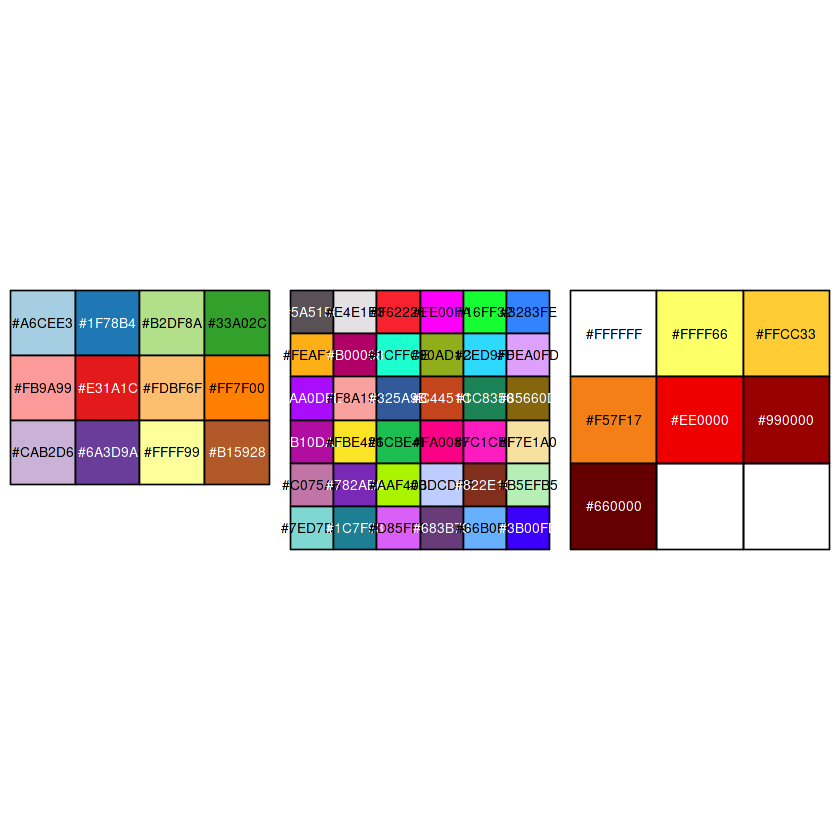

In [4]:
par(mfrow=c(1,3))
# method color
my_col_m <- brewer.pal(12, "Paired")
show_col(my_col_m)
# cell type color
my_col_c <- unlist(polychrome())
show_col(my_col_c)

my_color <- c("#FFFFFF","#FFFF66","#FFCC33","#F57F17","#EE0000","#990000","#660000")
show_col(my_color)

In [5]:
cross_table_plot <- function(ground_truth, clusterings, a=1.3, b=5.7, c=2){
    x <- unique(ground_truth)
    y <- as.factor(unique(clusterings))
    data <- expand.grid(X=x, Y=y)
    cross_count <- table(ground_truth, clusterings) 

    # cell count in the cross_count table
    data$Z1 <- apply(data, 1, function(x){cross_count[x[["X"]],as.numeric(x[["Y"]])]})
    # log transform Z1
    data$Z2 <- apply(data, 1, function(x){log(cross_count[x[["X"]],as.numeric(x[["Y"]])]+1)})
    # row normalize of Z1
    data <- data %>% group_by(X) %>% mutate(Z3 = 100*Z1/ARI(Z1))

    top_cluster <- data %>% group_by(X) %>% top_n(1, Z1)

    unselected_Y <- setdiff(unique(data$Y), unique(top_cluster$Y))
    top_cluster <- top_cluster[order(top_cluster$X),]
    new_levels <- as.numeric(c(as.character(unique(top_cluster$Y)),unselected_Y))
    data$Y <- factor(data$Y, levels=new_levels)

    res <- adjusted_wallance_indices(ground_truth, clusterings)

    df_awi <- do.call(rbind, Map(data.frame, "awi"=res$Awi))
    df_awi$cell_type <- levels(ground_truth)

    df_avj <- do.call(rbind, Map(data.frame, "avj"=res$Avj))
    df_avj$cell_type <- levels(clusterings)
    df_avj$cell_type <- factor(df_avj$cell_type, levels=new_levels)


    main <- ggplot(data, aes(Y, X, fill= Z3)) + 
    geom_tile(colour="black", size=0.1) + 
    scale_fill_gradientn(colours = my_color, breaks=seq(0,100,10), guide = guide_colourbar()) +
    labs(x="ATAC cluster", y="RNA cluster", fill = "Cells per RNA cluster %") + 
    theme(legend.direction = "horizontal", 
        legend.position = "bottom", 
        legend.key.width= unit(a, 'cm'),
        legend.text=element_text(size=12)) + 
    theme(plot.margin = unit(c(0, 0, 0, 1), "cm"),
        panel.background = element_blank(),
        axis.title.x = element_text(size = 15, margin = margin(5,0,0,0)), 
        axis.text.x = element_text(size = 12),
        axis.title.y = element_text(size = 15, margin = margin(0,0,0,0)), 
        axis.text.y = element_text(size = 12),)

    bp.x <- ggplot(data = df_avj, aes(x = cell_type, y = avj)) + 
    geom_bar(stat = "identity") + 
    theme(
        axis.title.x = element_blank(), 
        axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(), 
        axis.text.y = element_text(size=12), 
        axis.title.y = element_text(size = 15, margin = margin(10,5,0,0)),
        legend.position = "none",
        panel.background = element_blank()) + 
    labs(y = "Homogeneity")+ theme(plot.margin = unit(c(0, 0, 0, b), "cm"))

    bp.y <- ggplot(data = df_awi, aes(x = cell_type, y = awi)) + 
    geom_bar(stat = "identity") + coord_flip() + # theme_ipARI() + #theme_gray() +
    theme(axis.title.x = element_text(size = 15, margin = margin(5,5,0,0)), 
          axis.text.x = element_text(size = 12),
          axis.text.y = element_blank(), 
          axis.title.y = element_blank(), 
          axis.ticks.y = element_blank(), 
          legend.position="none",
          panel.background = element_blank()) + 
    labs(y="Completemess")+ theme(plot.margin = unit(c(0, 0, c, 0), "cm"))

    df_hm <- data.frame(cols = numeric(0), value = numeric(0))

    gg_empty <- df_hm %>% 
    ggplot(aes(x = cols, y = value)) +
    geom_blank() +
    theme(axis.text = element_blank(),
            axis.title = element_blank(),
            line = element_blank(),
            panel.background = element_blank()) + 
            geom_text(aes(label = paste0("ARI = ", round(res$ARI,3), "\n", "ARI2 = ", round(res$ARI2,3))), x = 0.5, y = 0.5)

    plot <- ggarrange(
    bp.x, gg_empty, main, bp.y,
    nrow = 2, ncol = 2, widths = c(3, 1), heights = c(1, 3)
    )

    return(plot)
}

In [6]:
library(aricode)

# Signac_all_cell_peaks

In [72]:
sobj1 <- readRDS("candidate1/Signac_all_cell_peaks_ndim15_r0.25seeds.RDS")

In [73]:
prediction_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/Signac/all_cell_peaks/0/default/15/r0.25.tsv"
clustering <- read.table(prediction_file, sep="\t")

In [74]:
meta <- sobj1[[]]
head(meta)

orig.ident
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG esophagus 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC esophagus 
                                                                            nCount_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              3102                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4617                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 13827                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4269                
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2462                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5627                
                                                                            nFeature_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              2799                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4283                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 11898                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4001                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2278                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5268                  
                                                                            ground_truth              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG Esophageal_Epithelial_Cell
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC Esophageal_Epithelial_Cell
                                                                            snn_ndim15_res.0.25
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3                  
                                                                            seurat_clusters
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3              
                                            

In [52]:
ARI(meta$Signac_all_cell_peaks_ndim15_r0.25_seed197, clustering$clusterings)
ARI(meta$Signac_all_cell_peaks_ndim15_r0.25_seed123, clustering$clusterings)
ARI(meta$Signac_all_cell_peaks_ndim15_r0.25_seed5, clustering$clusterings)
ARI(meta$Signac_all_cell_peaks_ndim15_r0.25_seed2, clustering$clusterings)
ARI(meta$Signac_all_cell_peaks_ndim15_r0.25_seed42, clustering$clusterings)

[1] 0.9966635

[1] 1

[1] 1

[1] 1

[1] 1

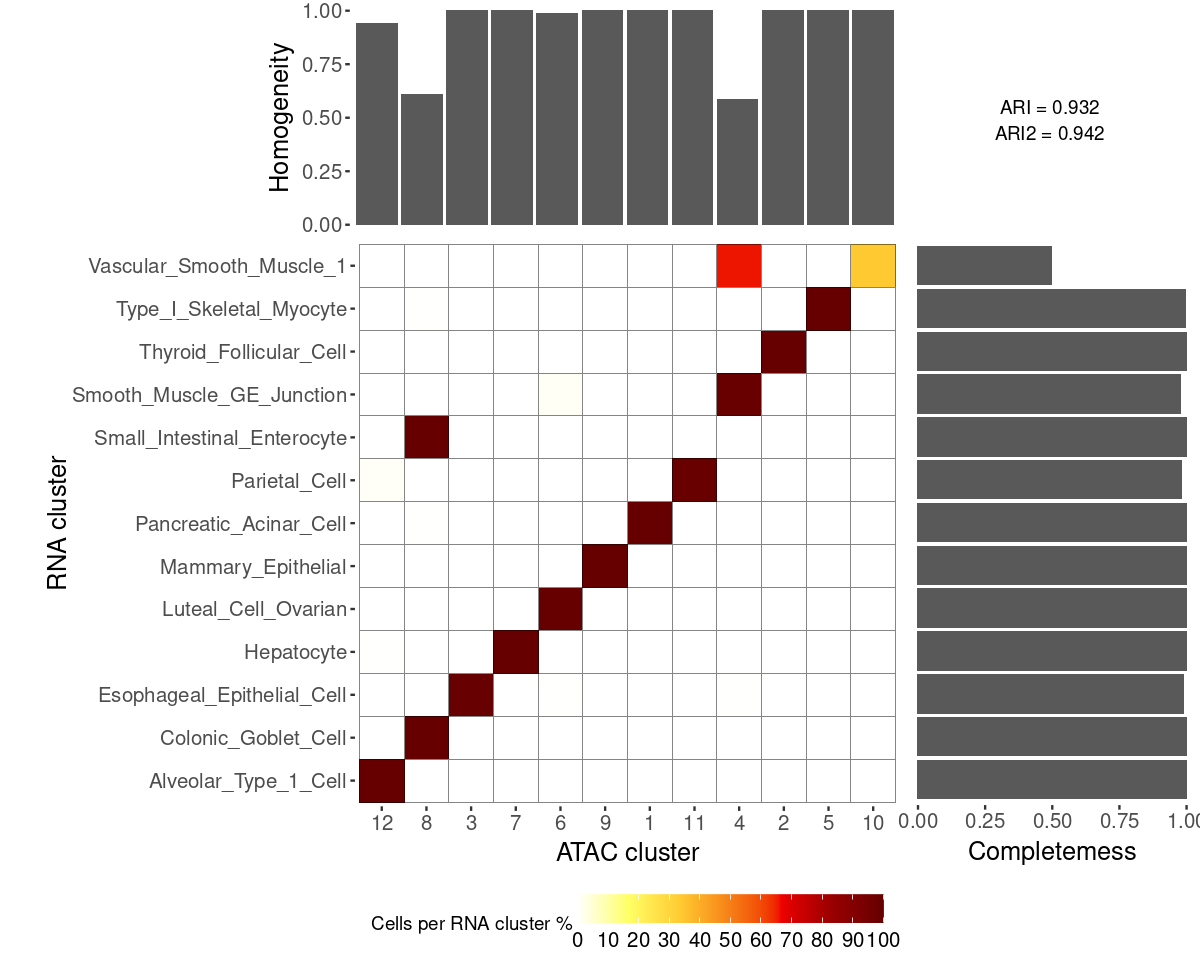

In [75]:
ground_truth <- sobj1$ground_truth
options(repr.plot.width=10, repr.plot.height=8)
cross_table_plot(ground_truth, meta$Signac_all_cell_peaks_ndim15_r0.25_seed197, a=1.3, b=5.7, c=2)

# Signac_by_cluster_peaks

In [7]:
sobj1 <- readRDS("candidate1/Signac_by_cluster_peaks_ndim15_r0.25seeds.RDS")

In [8]:
prediction_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/Signac/by_cluster_peaks/0/default/15/r0.25.tsv"
clustering <- read.table(prediction_file, sep="\t")

In [9]:
meta <- sobj1[[]]
head(meta)

orig.ident
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG esophagus 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC esophagus 
                                                                            nCount_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              3102                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4617                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 13827                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4269                
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2462                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5627                
                                                                            nFeature_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              2799                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4283                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 11898                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4001                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2278                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5268                  
                                                                            ground_truth              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG Esophageal_Epithelial_Cell
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC Esophageal_Epithelial_Cell
                                                                            snn_ndim15_res.0.25
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3                  
                                                                            seurat_clusters
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3              
                                            

In [95]:
ARI(meta$Signac_by_cluster_peaks_ndim15_r0.25_seed197 , clustering$clusterings) 
ARI(meta$Signac_by_cluster_peaks_ndim15_r0.25_seed123 , clustering$clusterings) 
ARI(meta$Signac_by_cluster_peaks_ndim15_r0.25_seed5 , clustering$clusterings) 
ARI(meta$Signac_by_cluster_peaks_ndim15_r0.25_seed2 , clustering$clusterings) 
ARI(meta$Signac_by_cluster_peaks_ndim15_r0.25_seed42 , clustering$clusterings) 

[1] 0.9478233

[1] 0.9996239

[1] 1

[1] 0.9469933

[1] 0.9475891

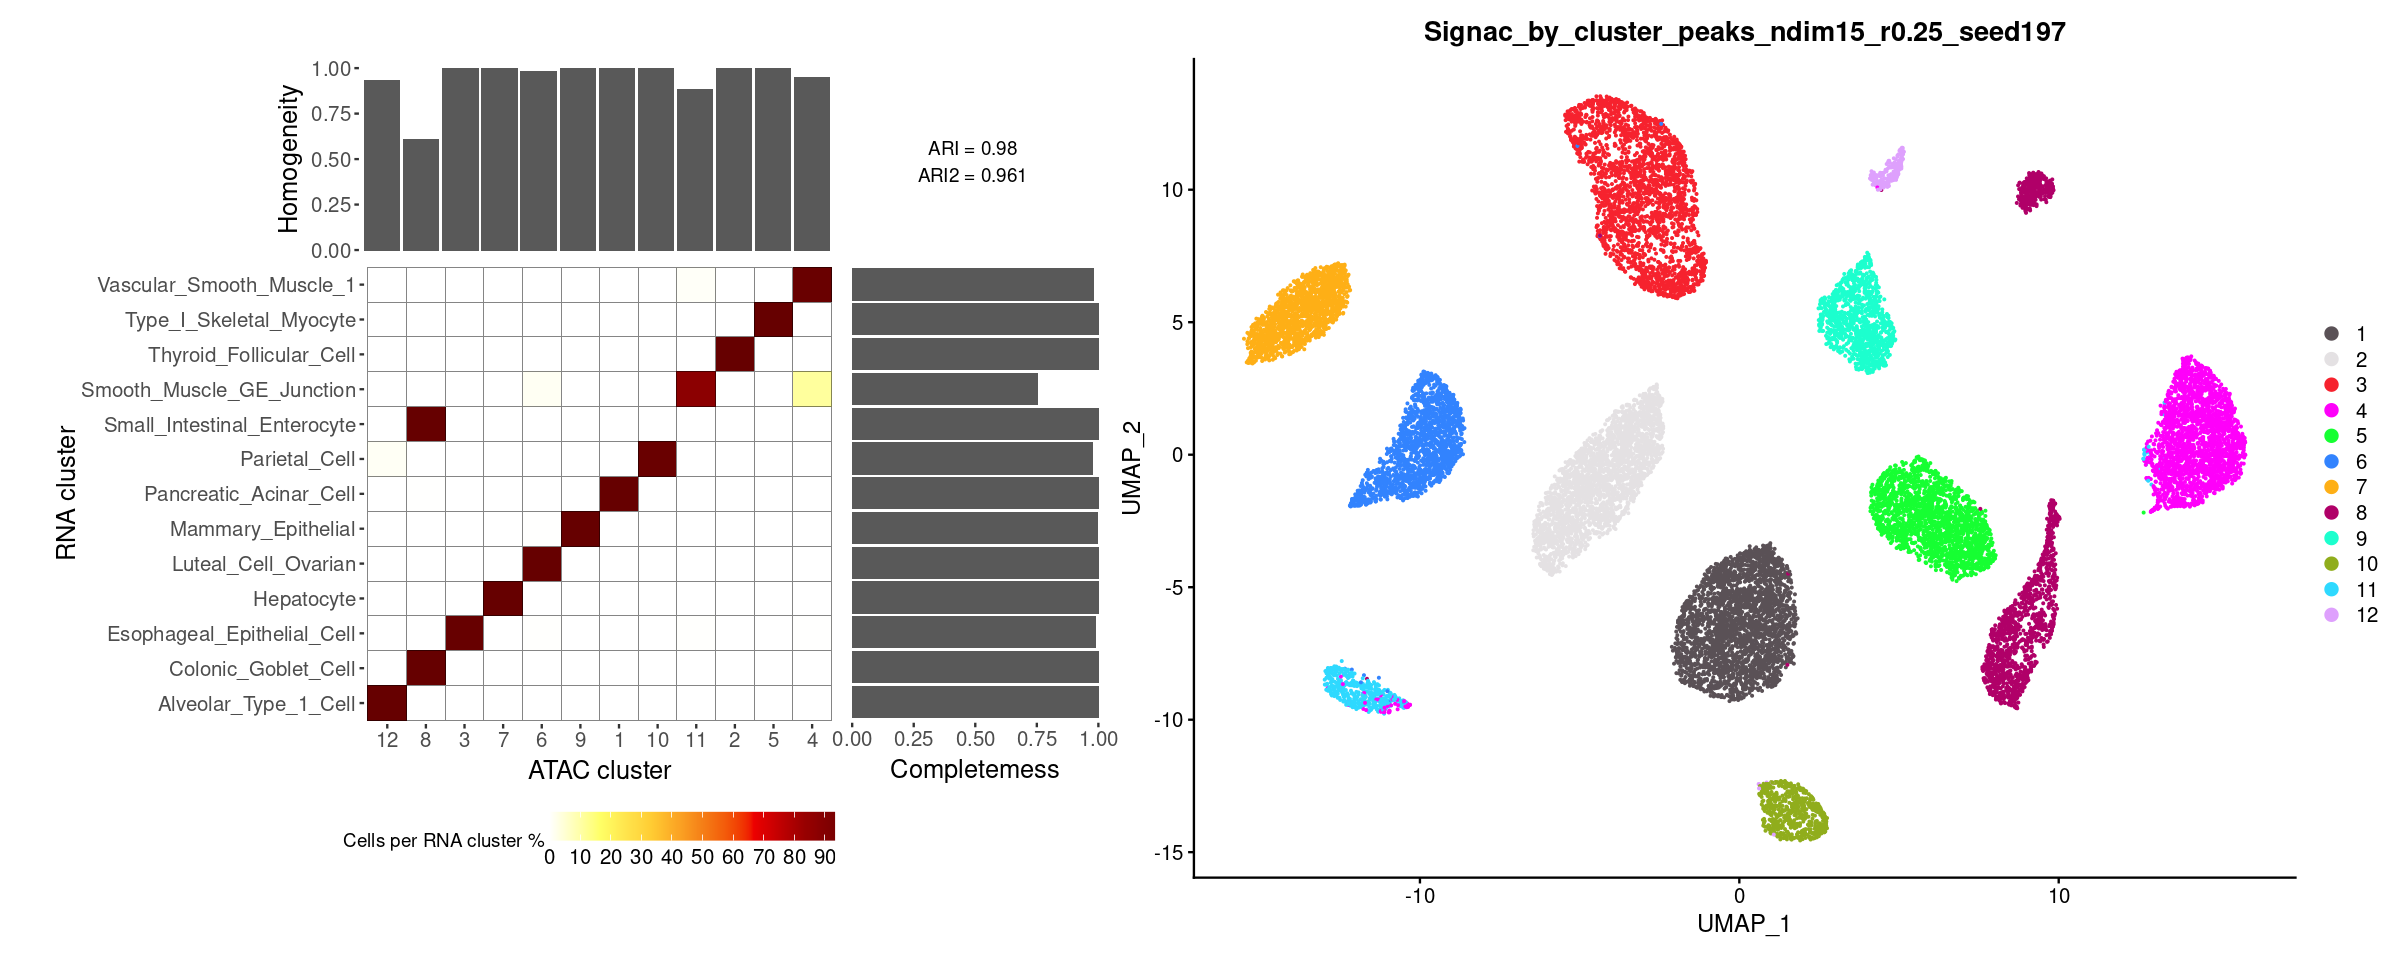

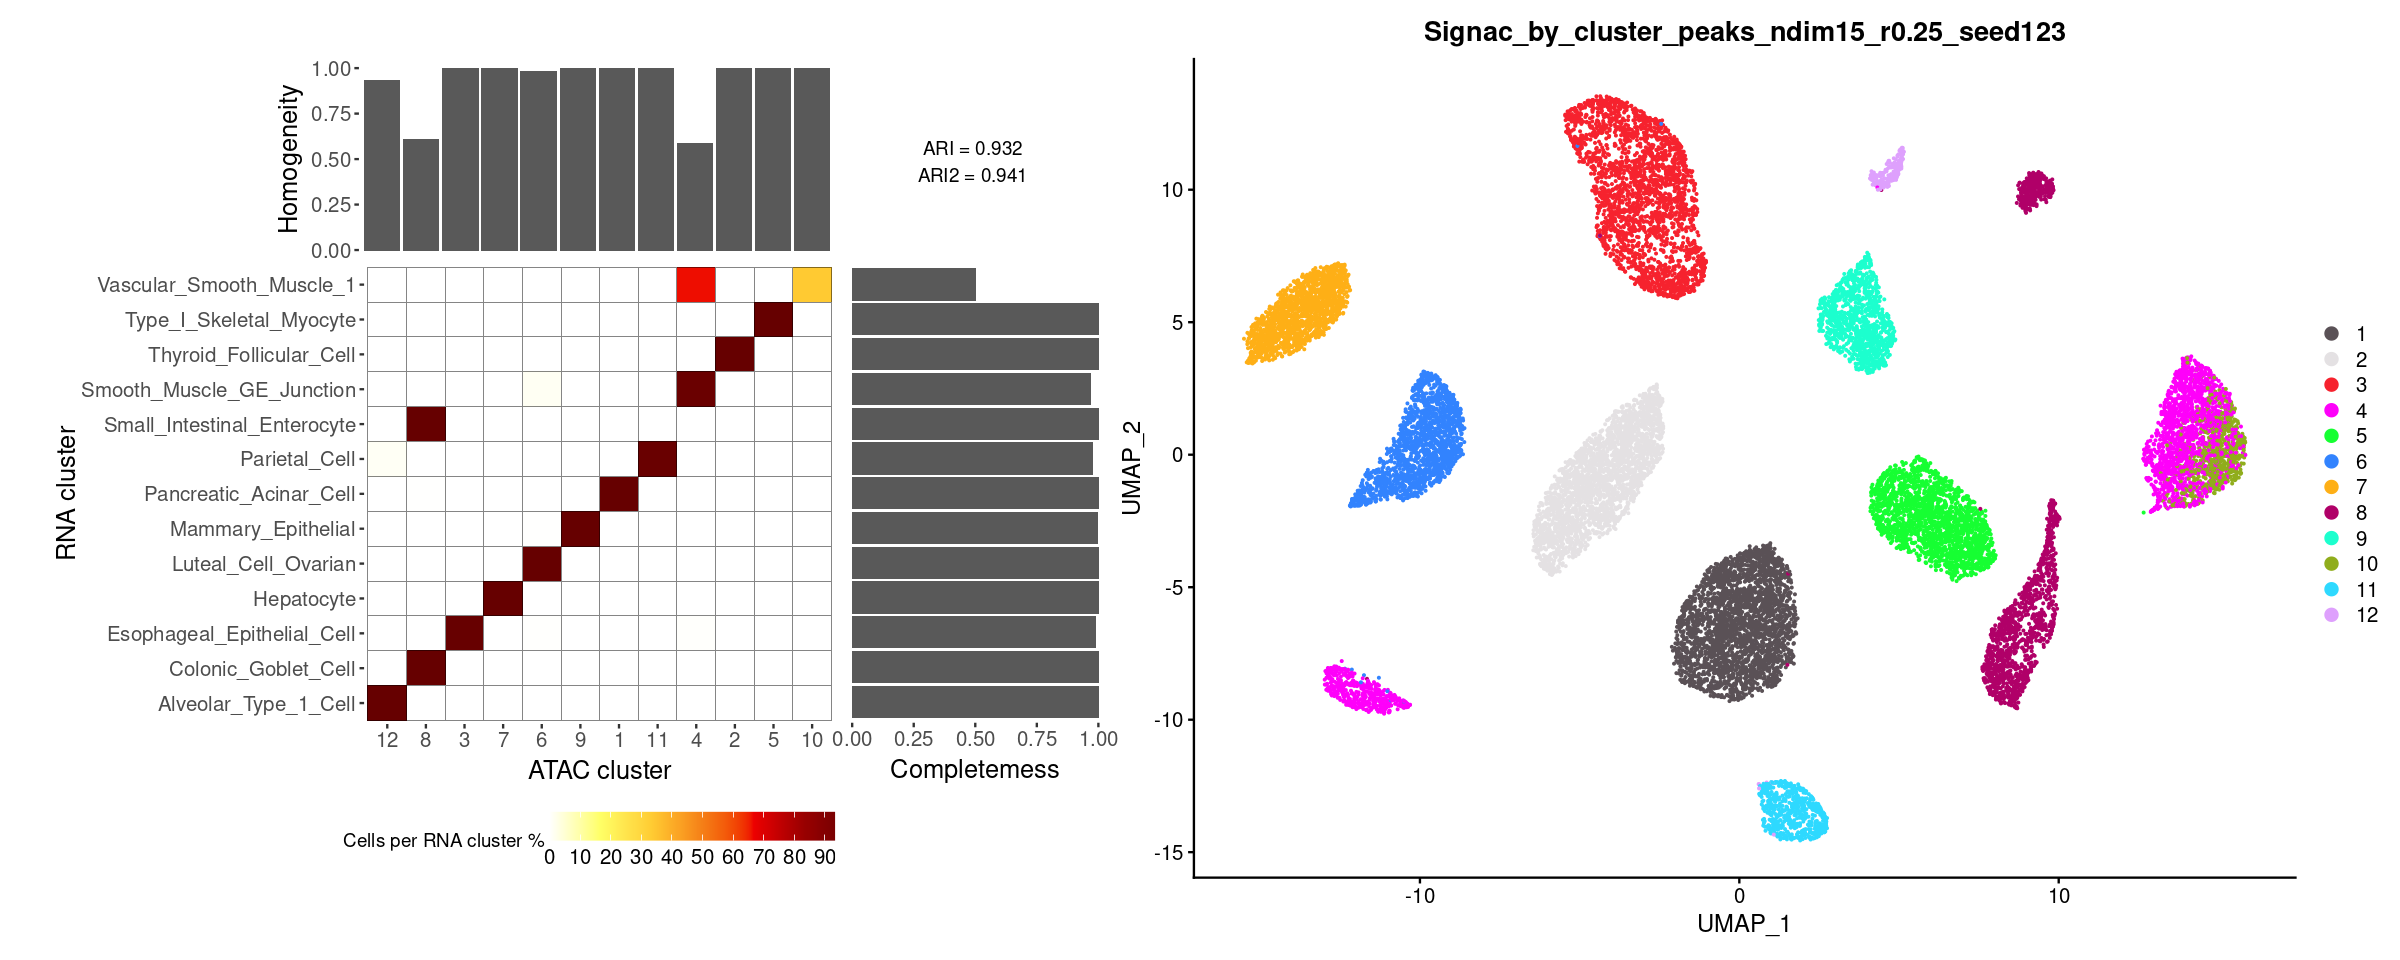

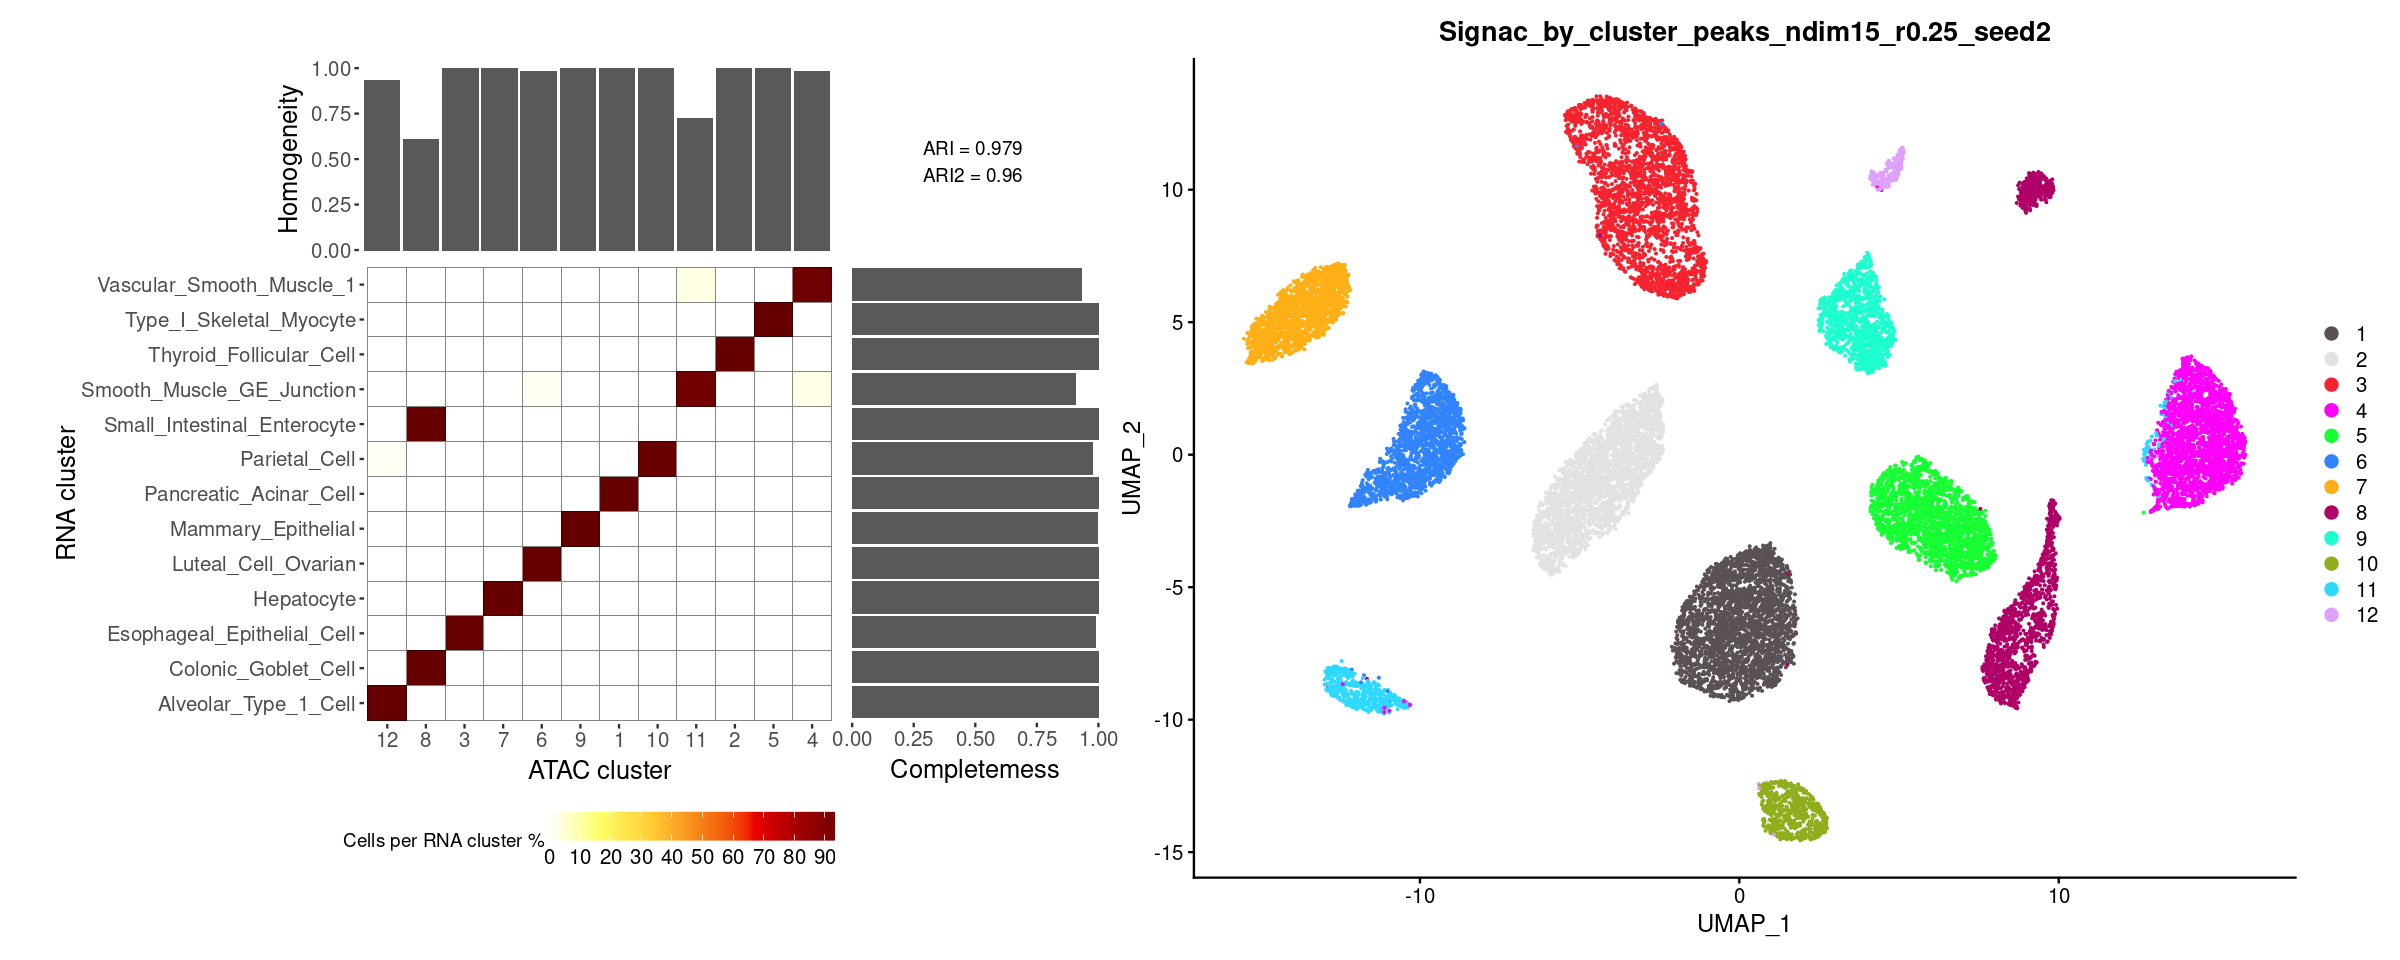

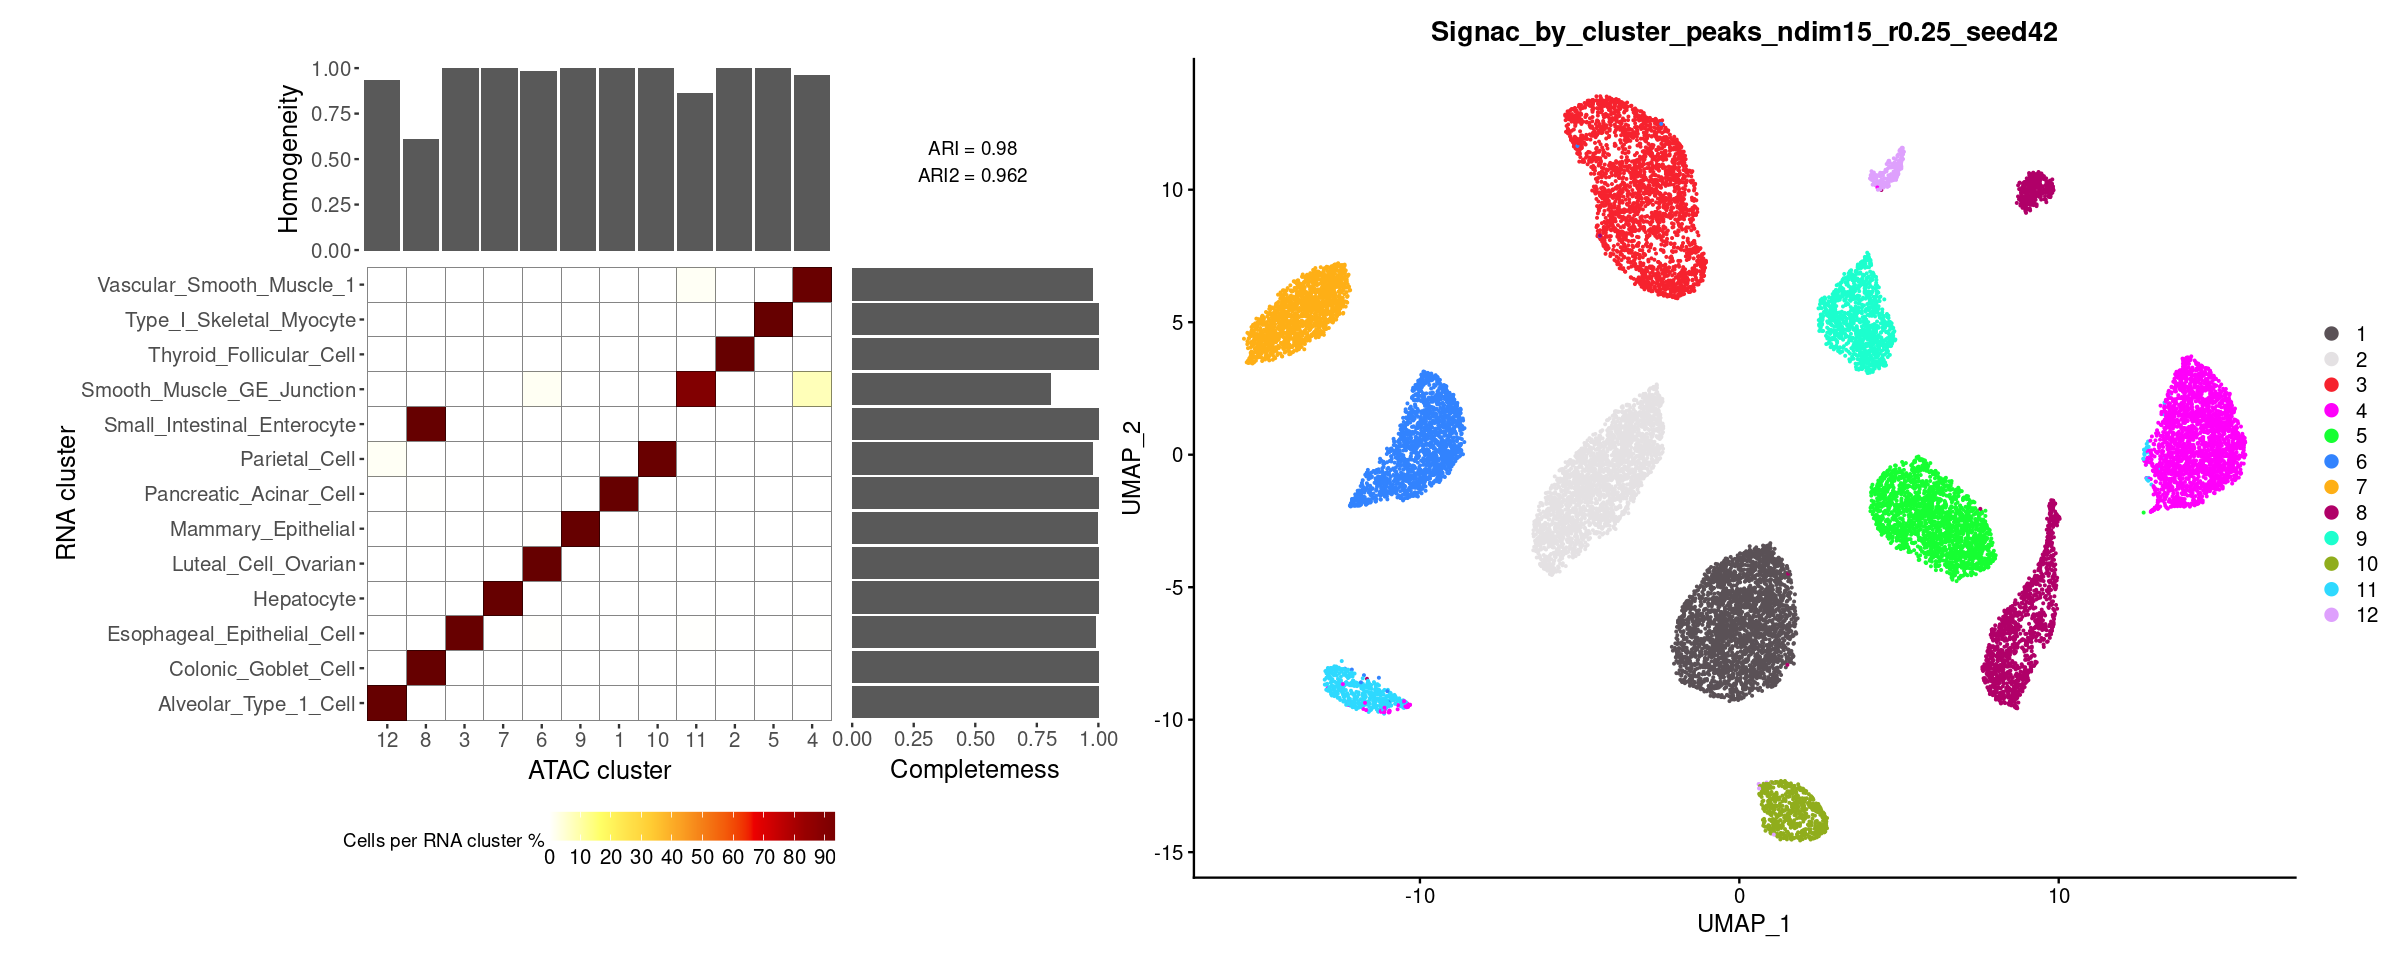

In [98]:
ground_truth <- sobj1$ground_truth
options(repr.plot.width=20, repr.plot.height=8)
p1 <- cross_table_plot(ground_truth, meta$Signac_by_cluster_peaks_ndim15_r0.25_seed197, a=1.3, b=5.7, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = "Signac_by_cluster_peaks_ndim15_r0.25_seed197", cols="polychrome")
p1 + p2
p1 <- cross_table_plot(ground_truth, meta$Signac_by_cluster_peaks_ndim15_r0.25_seed123, a=1.3, b=5.7, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = "Signac_by_cluster_peaks_ndim15_r0.25_seed123", cols="polychrome")
p1 + p2
p1 <- cross_table_plot(ground_truth, meta$Signac_by_cluster_peaks_ndim15_r0.25_seed2, a=1.3, b=5.7, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = "Signac_by_cluster_peaks_ndim15_r0.25_seed2", cols="polychrome")
p1 + p2
p1 <- cross_table_plot(ground_truth, meta$Signac_by_cluster_peaks_ndim15_r0.25_seed42, a=1.3, b=5.7, c=2)
p2 <- DimPlot(sobj1, reduction = "umap", label = F, repel=T, 
        group.by = "Signac_by_cluster_peaks_ndim15_r0.25_seed42", cols="polychrome")
p1 + p2


Signac_all_cell_peaks has very stable solutions across different random seed. Signac_by_cluster_peaks has more variable solutions, and for some solution, it can seperate two types of smooth muscle cells. This confirms the hypothesis that the feature itself contains the information that seperates these two classes, which is consistent with the UMAP result. But the graph-based clustering algorithm sometimes fail to seperate the two modules.

In [10]:
sobj2 <- readRDS("/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/aggregation/default/0/default/15/sobj_SNN.RDS")

In [19]:
ground_truth <- sobj2$ground_truth

Loading required package: Signac



## Check the SNN graph

In [11]:
g1 <- sobj1@graphs[['snn_ndim15']]
attributes(g1)$class <- "dgCMatrix"

g2 <- sobj2@graphs[['snn_ndim15']]
attributes(g2)$class <- "dgCMatrix"

In [12]:
g1 <- graph_from_adjacency_matrix(adjmatrix = g1, mode = "undirected", weighted = TRUE, add.colnames = TRUE)
g2 <- graph_from_adjacency_matrix(adjmatrix = g2, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

In [13]:
edge_density(g1)
edge_density(g2)

[1] 0.003368453

[1] 0.003658011

In [64]:
unique(ground_truth)

[1] Pancreatic_Acinar_Cell      Esophageal_Epithelial_Cell 
 [3] Small_Intestinal_Enterocyte Vascular_Smooth_Muscle_1   
 [5] Thyroid_Follicular_Cell     Luteal_Cell_Ovarian        
 [7] Hepatocyte                  Colonic_Goblet_Cell        
 [9] Parietal_Cell               Smooth_Muscle_GE_Junction  
[11] Mammary_Epithelial          Type_I_Skeletal_Myocyte    
[13] Alveolar_Type_1_Cell       
13 Levels: Alveolar_Type_1_Cell ... Vascular_Smooth_Muscle_1

### Homophily

In [60]:
graph_homophily <- function(graph, label){
    require(igraph)
    V(graph)$label <- label
    label_ls <- unique(label)
    n_edges <- length(E(graph))
    n_nodes <- length(V(graph))
    connectance <- 2 * n_edges / n_nodes / (n_nodes - 1)
    n_nodes_1 <- sum(V(graph)$label == label_ls[1])
    n_nodes_2 <- sum(V(graph)$label == label_ls[2])
    
    idx <- V(graph)$label == label_ls[1]
    v1 <- V(graph)[idx]
    v2 <- V(graph)[!idx]
    g1 <- subgraph(graph, v1)
    g2 <- subgraph(graph, v2)
    n_edges_1 <- length(E(g1))
    n_edges_2 <- length(E(g2))
    
    expected_dyad_1 <- n_nodes_1 * (n_nodes_1-1) * connectance/2
    dyad_1 <- n_edges_1/ expected_dyad_1
    expected_dyad_2 <- n_nodes_2 * (n_nodes_2-1) * connectance/2
    dyad_2 <- n_edges_2/ expected_dyad_2
    
    mixed_edges <- n_edges - n_edges_1 - n_edges_2
    
    expected_het <- n_nodes_1 * n_nodes_2 * connectance
    het <- mixed_edges / expected_het
    
    return(list("connectance"=connectance, "het"=het, "dyad_1" = dyad_1, "dyad_2"=dyad_2))
    }

#### Muscle

In [89]:
idx <- ground_truth == "Vascular_Smooth_Muscle_1" | ground_truth == "Smooth_Muscle_GE_Junction" 
muscle_v1 <- V(g1)[idx]
muscle_v2 <- V(g2)[idx]
g1_muscle <- subgraph(g1, muscle_v1)
g2_muscle <- subgraph(g2, muscle_v2)

In [90]:
graph_homophily(g1_muscle, V(g1_muscle)$cluster)

$connectance
[1] 0.02409412

$het
[1] 0.09230486

$dyad_1
[1] 1.2144

$dyad_2
[1] 4.804944

In [91]:
V(g1_muscle)$color <- V(g1_muscle)$cluster
V(g1_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g1_muscle)$color)
V(g1_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g1_muscle)$color)

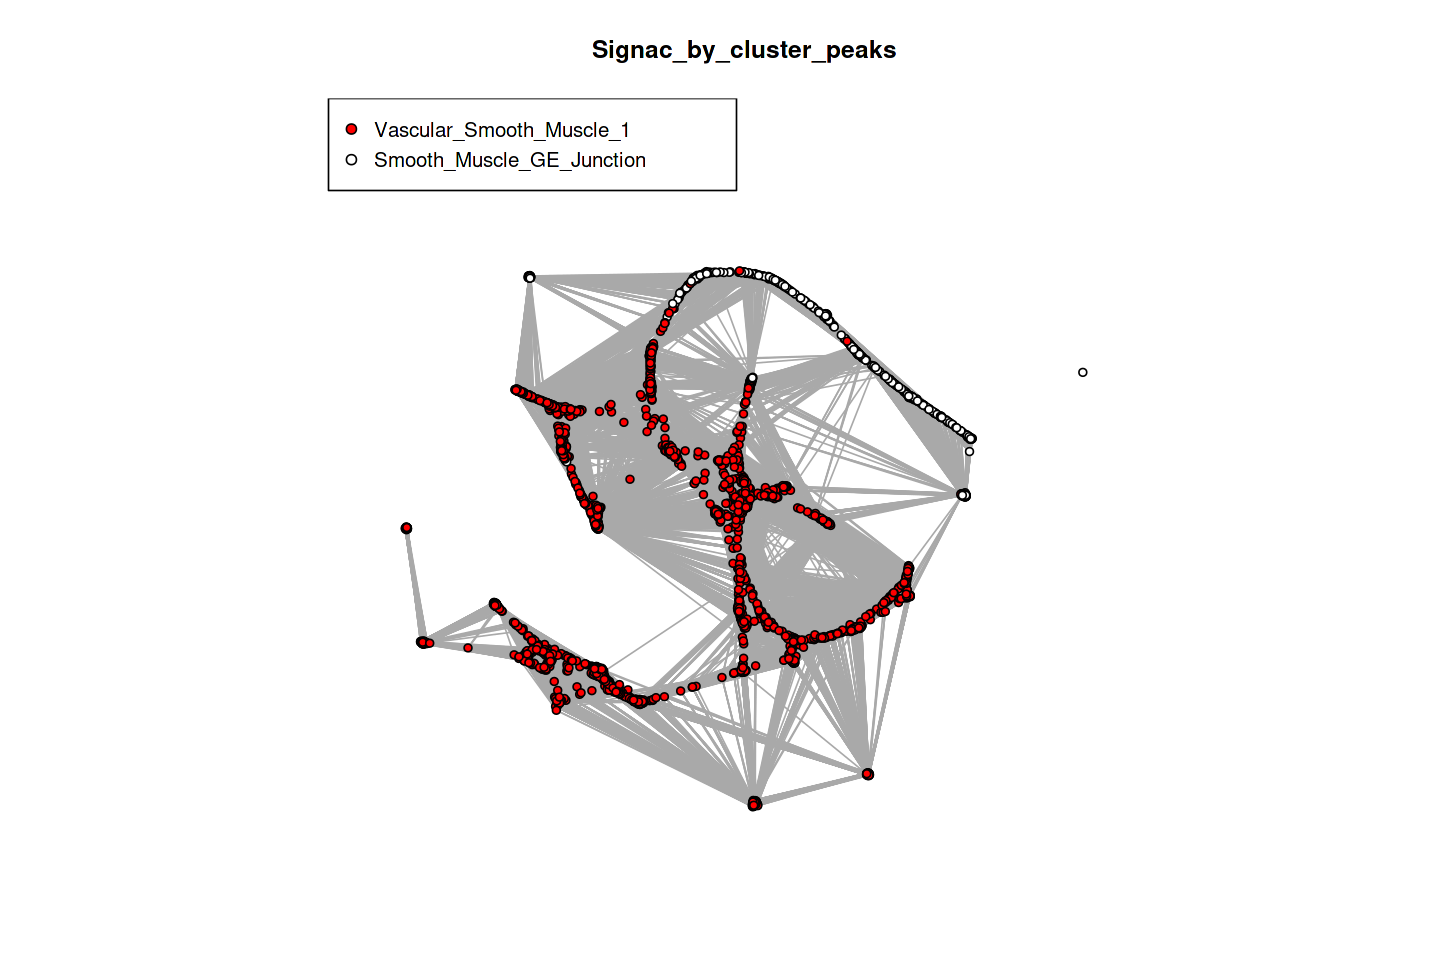

In [93]:
options(repr.plot.width=12, repr.plot.height=8)
plot(simplify(g1_muscle), vertex.label=NA, vertex.size=2, main="Signac_by_cluster_peaks")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))
# plot(simplify(g1_muscle), vertex.label=NA, vertex.size=2, layout=layout.fruchterman.reingold)

In [95]:
graph_homophily(g2_muscle, V(g2_muscle)$cluster)

$connectance
[1] 0.02580821

$het
[1] 0.09862725

$dyad_1
[1] 1.163486

$dyad_2
[1] 5.874114

In [96]:
V(g2_muscle)$color <- V(g2_muscle)$cluster
V(g2_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g2_muscle)$color)
V(g2_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g2_muscle)$color)

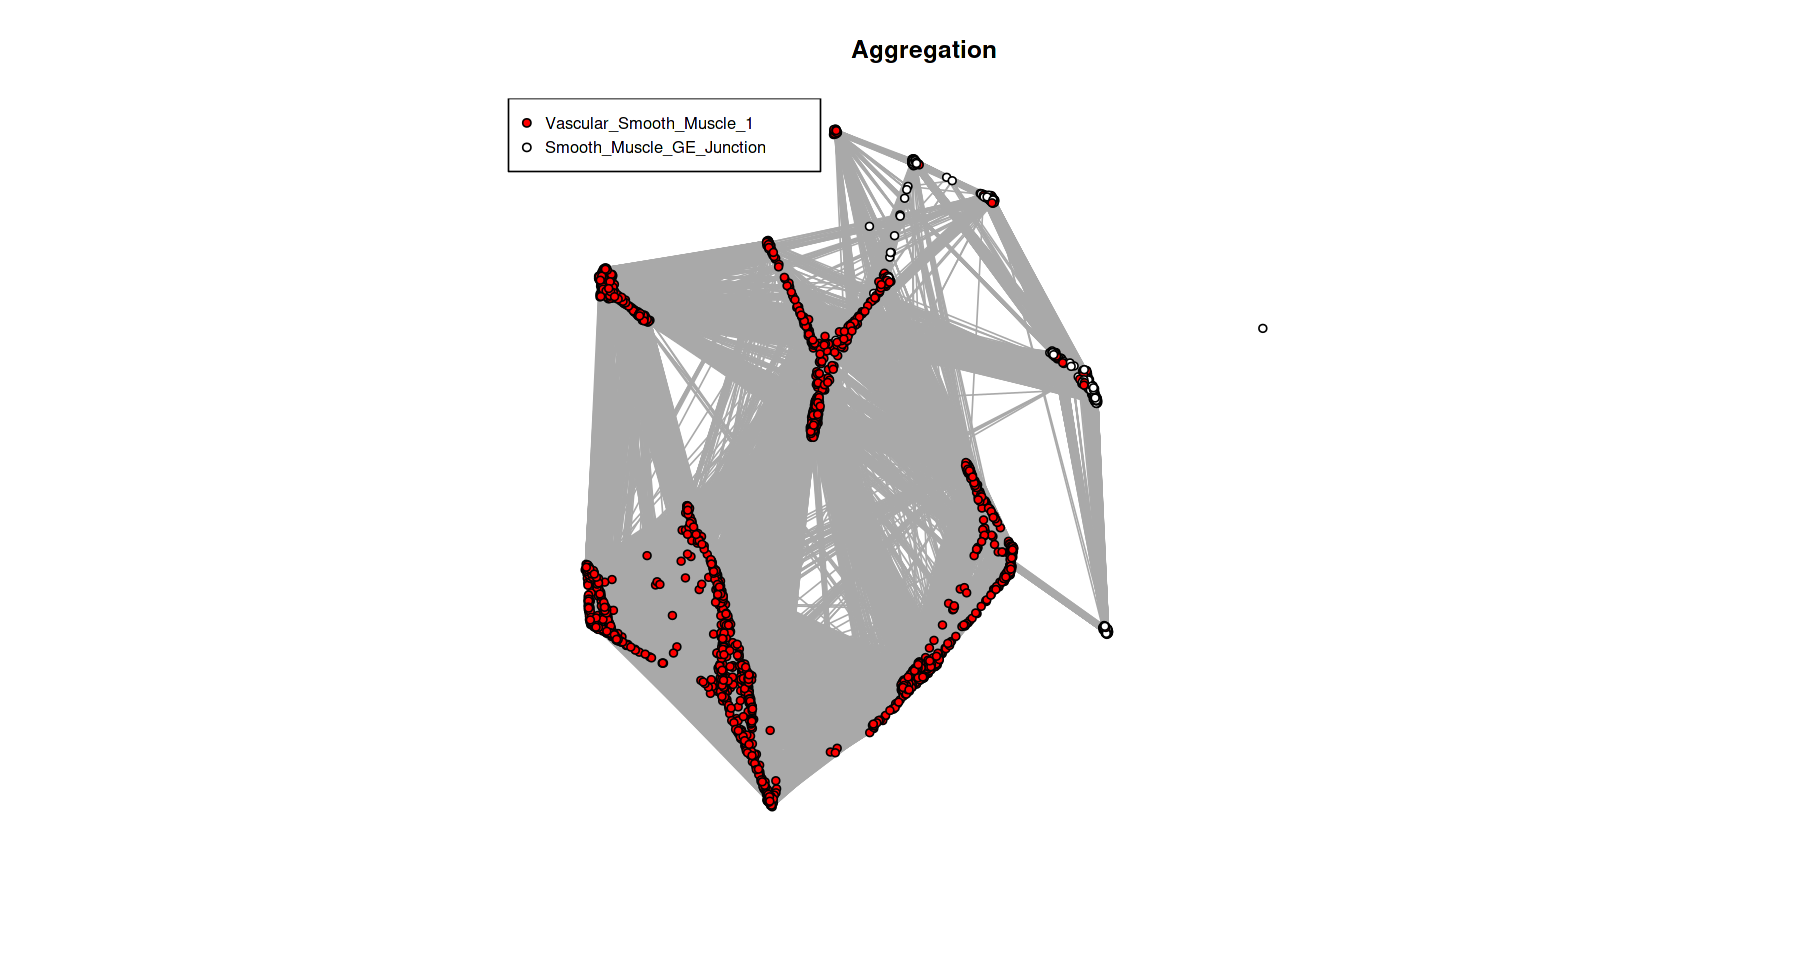

In [110]:
options(repr.plot.width=15, repr.plot.height=8)
plot(simplify(g2_muscle), vertex.label=NA, vertex.size=2, main="Aggregation") # remove loops and duplicated edges
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"), cex=0.8)

#### Small intestinal

In [153]:
idx <- ground_truth == "Small_Intestinal_Enterocyte" | ground_truth == "Colonic_Goblet_Cell" 
s_v1 <- V(g1)[idx]
s_v2 <- V(g2)[idx]
g1_s <- subgraph(g1, s_v1)
g2_s <- subgraph(g2, s_v2)
graph_homophily(g1_s, V(g1_s)$cluster)
graph_homophily(g1_s, V(g1_s)$cluster)

$connectance
[1] 0.03850827

$het
[1] 0.09729695

$dyad_1
[1] 1.256766

$dyad_2
[1] 4.184091

$connectance
[1] 0.03850827

$het
[1] 0.09729695

$dyad_1
[1] 1.256766

$dyad_2
[1] 4.184091

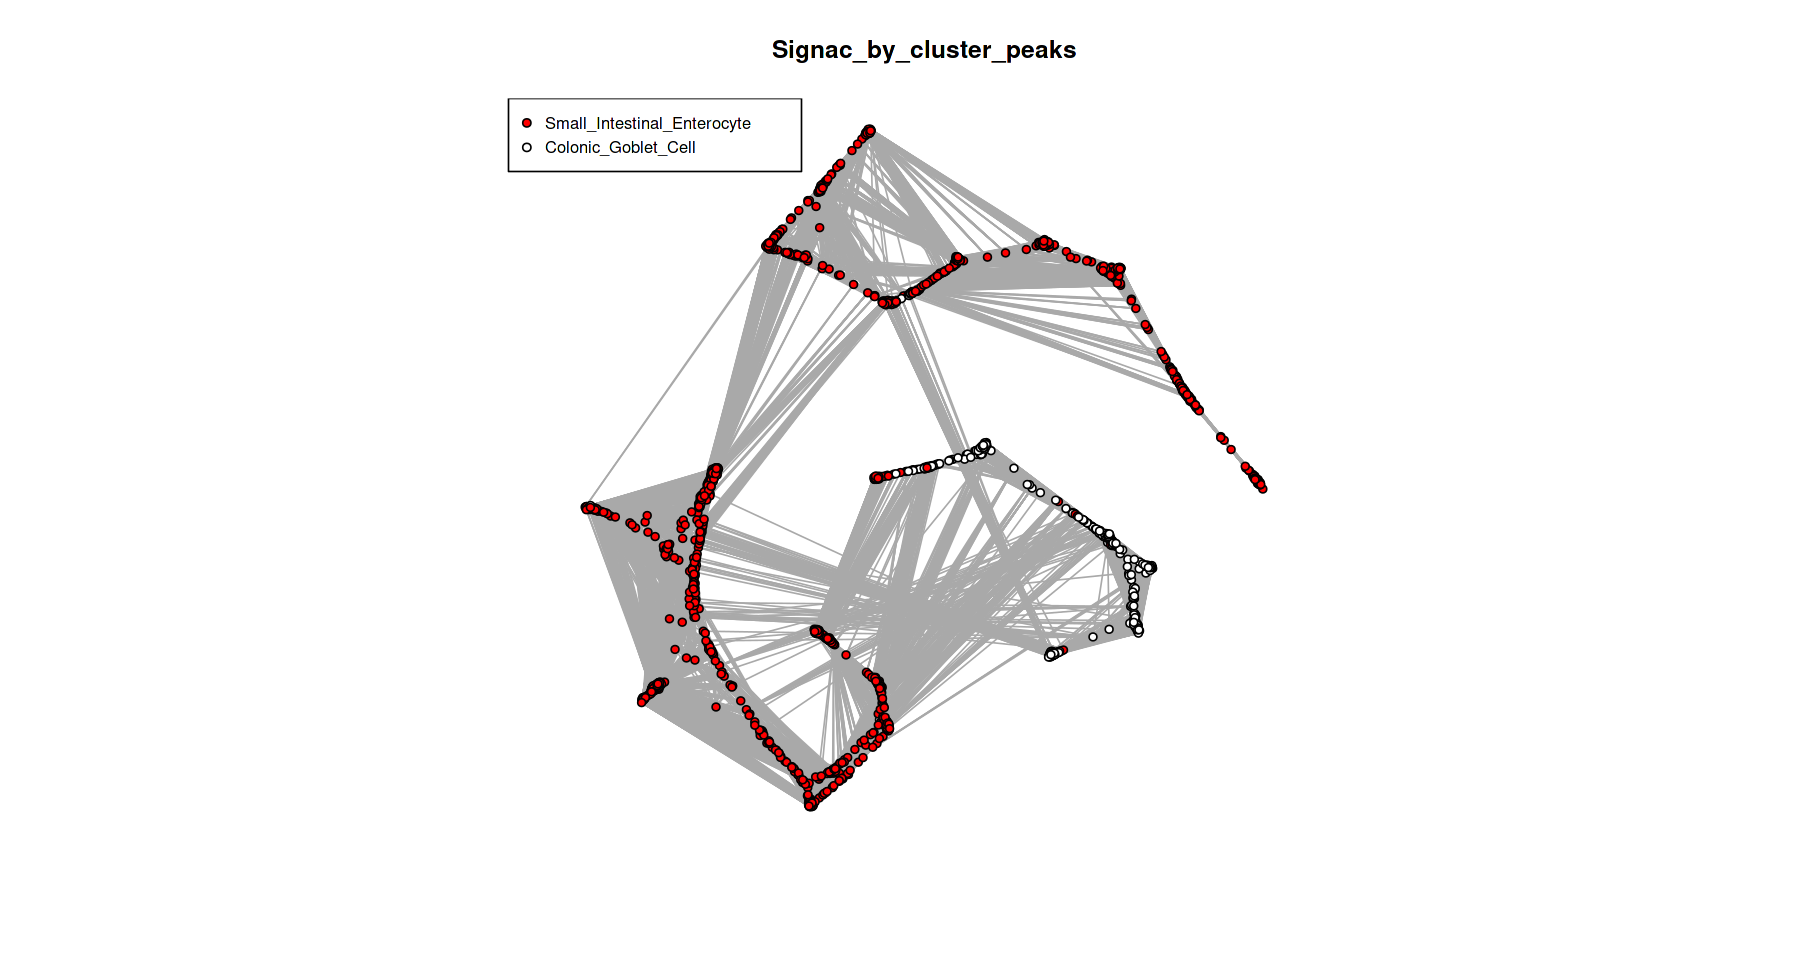

In [106]:
V(g1_s)$color <- V(g1_s)$cluster
V(g1_s)$color <- gsub("Small_Intestinal_Enterocyte","red", V(g1_s)$color)
V(g1_s)$color <- gsub("Colonic_Goblet_Cell" ,"white", V(g1_s)$color)
V(g2_s)$color <- V(g2_s)$cluster
V(g2_s)$color <- gsub("Small_Intestinal_Enterocyte","red", V(g2_s)$color)
V(g2_s)$color <- gsub("Colonic_Goblet_Cell" ,"white", V(g2_s)$color)
options(repr.plot.width=15, repr.plot.height=8)
plot(simplify(g1_s), vertex.label=NA, vertex.size=2, main="Signac_by_cluster_peaks") # remove loops and duplicated edges
legend("topleft", legend=c("Small_Intestinal_Enterocyte", "Colonic_Goblet_Cell"), pch=21, pt.bg=c("red","white"), cex=0.8)

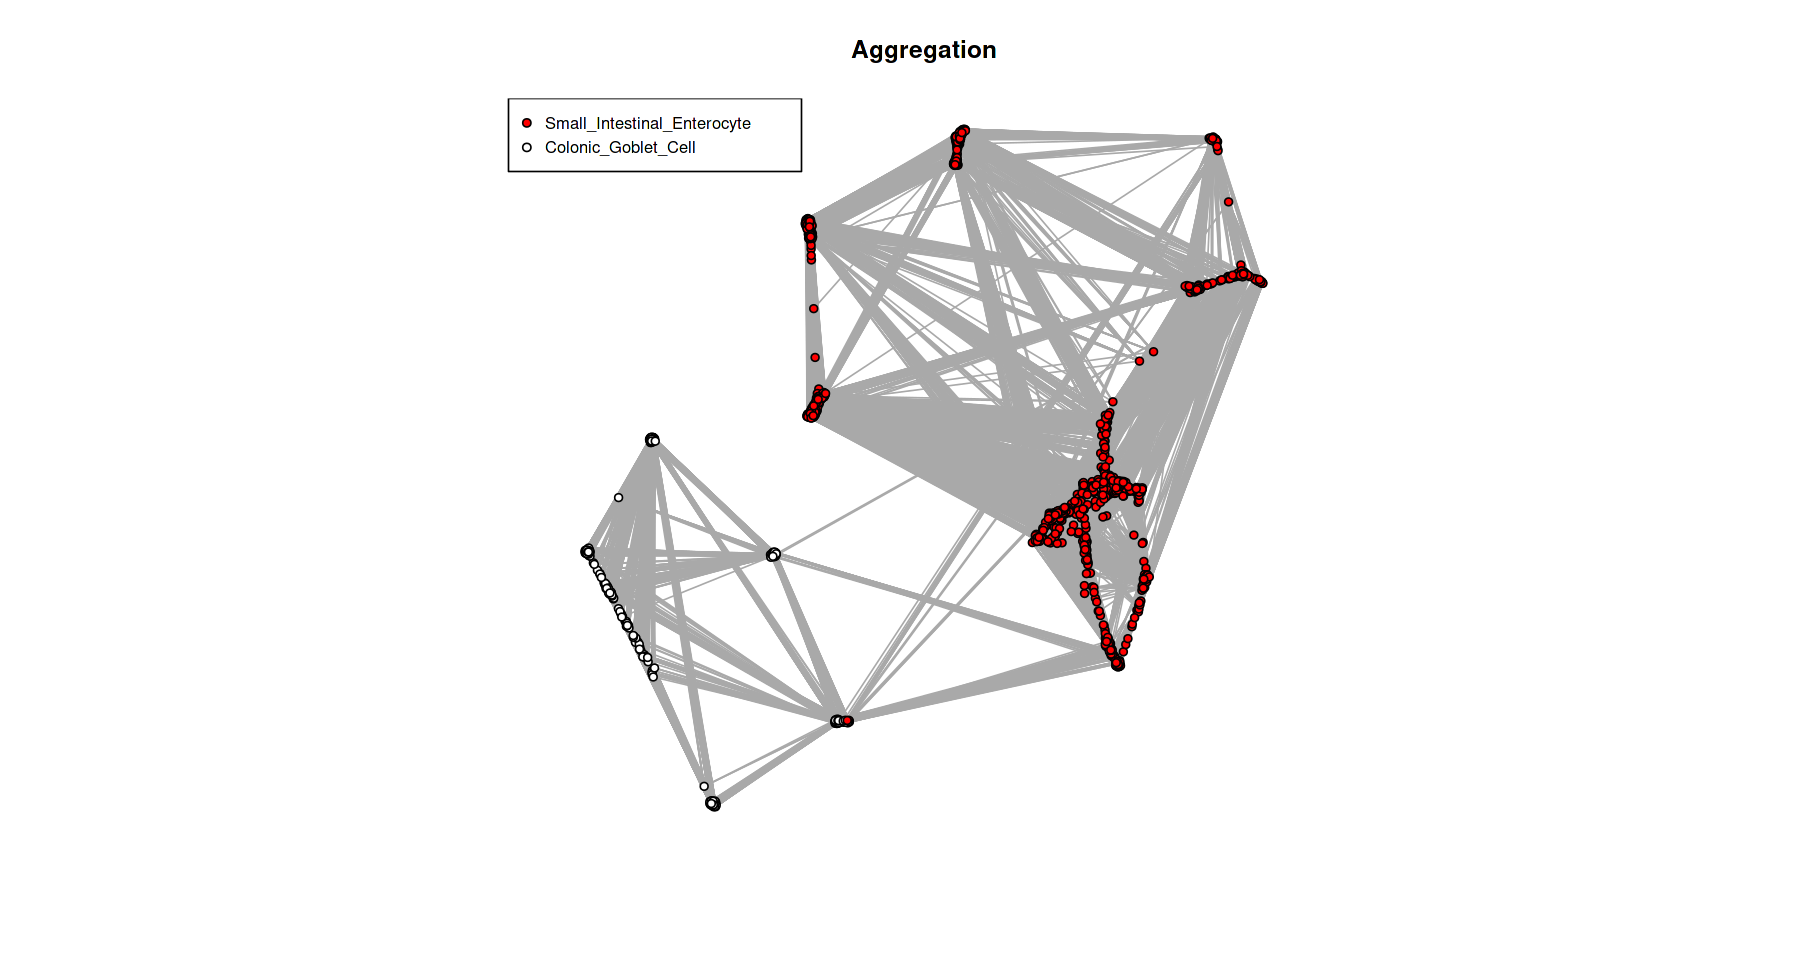

In [109]:
options(repr.plot.width=15, repr.plot.height=8)
plot(simplify(g2_s), vertex.label=NA, vertex.size=2, main="Aggregation") # remove loops and duplicated edges
legend("topleft", legend=c("Small_Intestinal_Enterocyte", "Colonic_Goblet_Cell"), pch=21, pt.bg=c("red","white"), cex=0.8)

#### Others

In [155]:
idx <- ground_truth == "Type_I_Skeletal_Myocyte" | ground_truth == "Pancreatic_Acinar_Cell" 
s_v1 <- V(g1)[idx]
s_v2 <- V(g2)[idx]
g1_s <- subgraph(g1, s_v1)
g2_s <- subgraph(g2, s_v2)
graph_homophily(g1_s, V(g1_s)$cluster)
graph_homophily(g1_s, V(g1_s)$cluster)

$connectance
[1] 0.01356635

$het
[1] 7.357702e-05

$dyad_1
[1] 1.693327

$dyad_2
[1] 2.441393

$connectance
[1] 0.01356635

$het
[1] 7.357702e-05

$dyad_1
[1] 1.693327

$dyad_2
[1] 2.441393

In [156]:
V(g1_s)$color <- V(g1_s)$cluster
V(g1_s)$color <- gsub("Type_I_Skeletal_Myocyte","red", V(g1_s)$color)
V(g1_s)$color <- gsub("Pancreatic_Acinar_Cell" ,"white", V(g1_s)$color)
V(g2_s)$color <- V(g2_s)$cluster
V(g2_s)$color <- gsub("Type_I_Skeletal_Myocyte","red", V(g2_s)$color)
V(g2_s)$color <- gsub("Pancreatic_Acinar_Cell" ,"white", V(g2_s)$color)

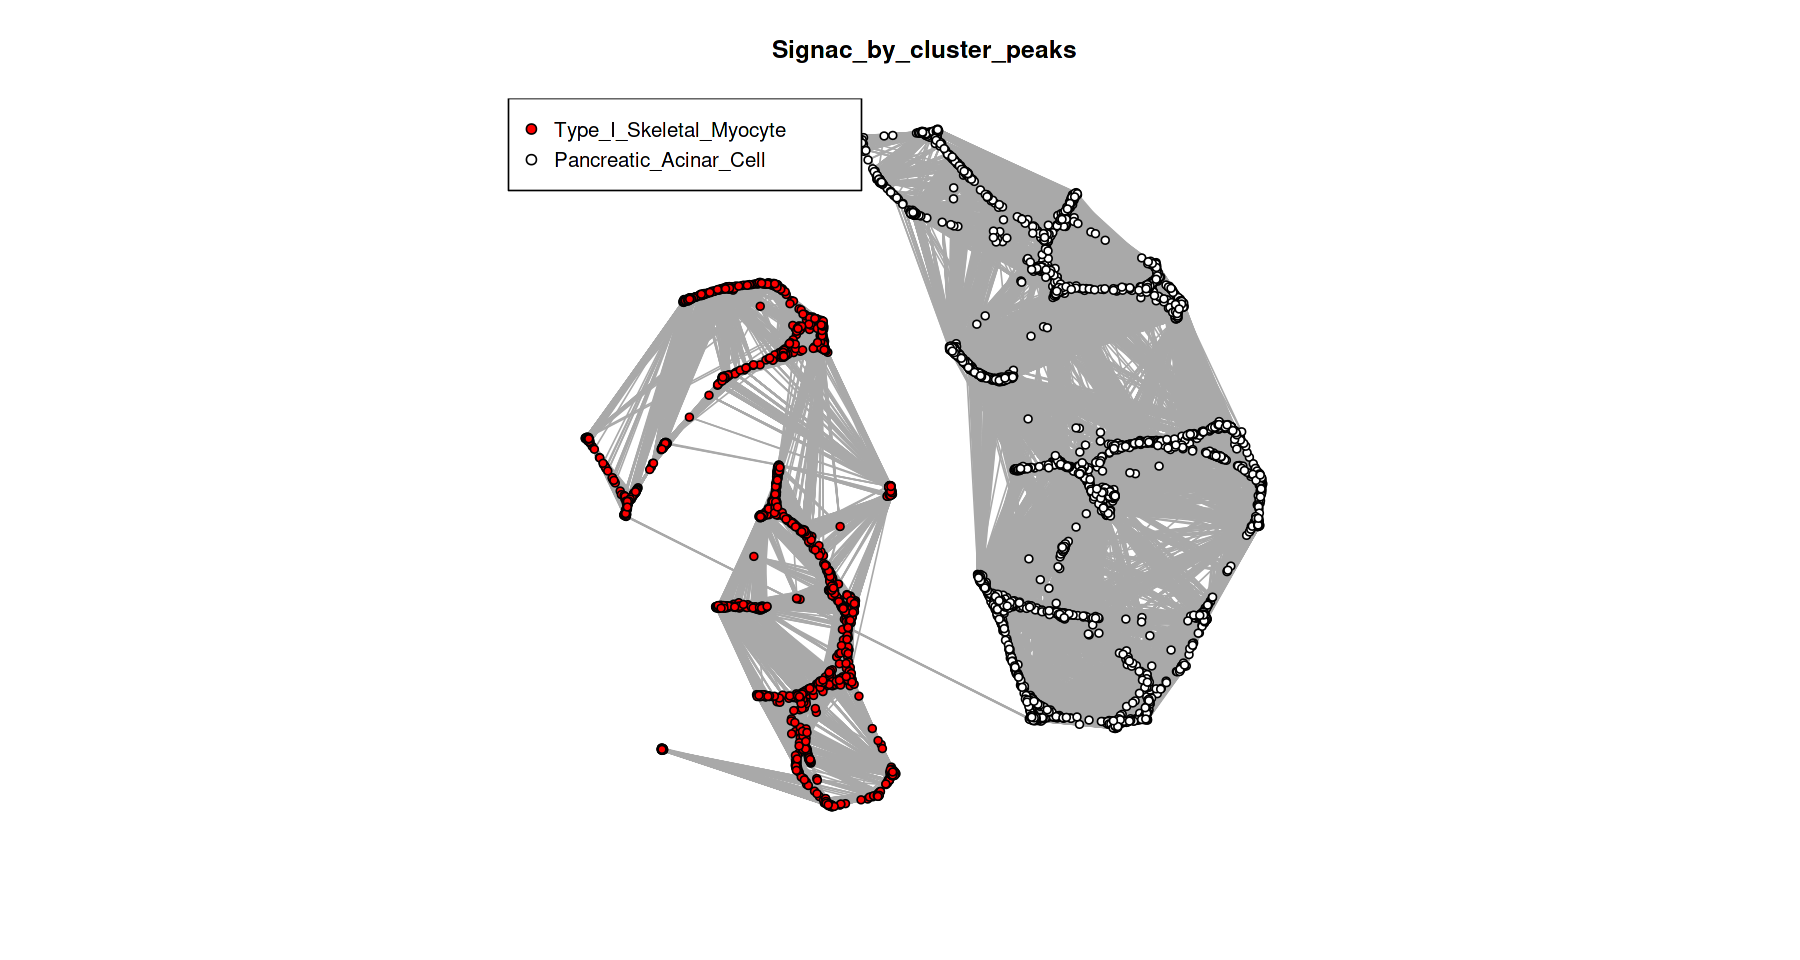

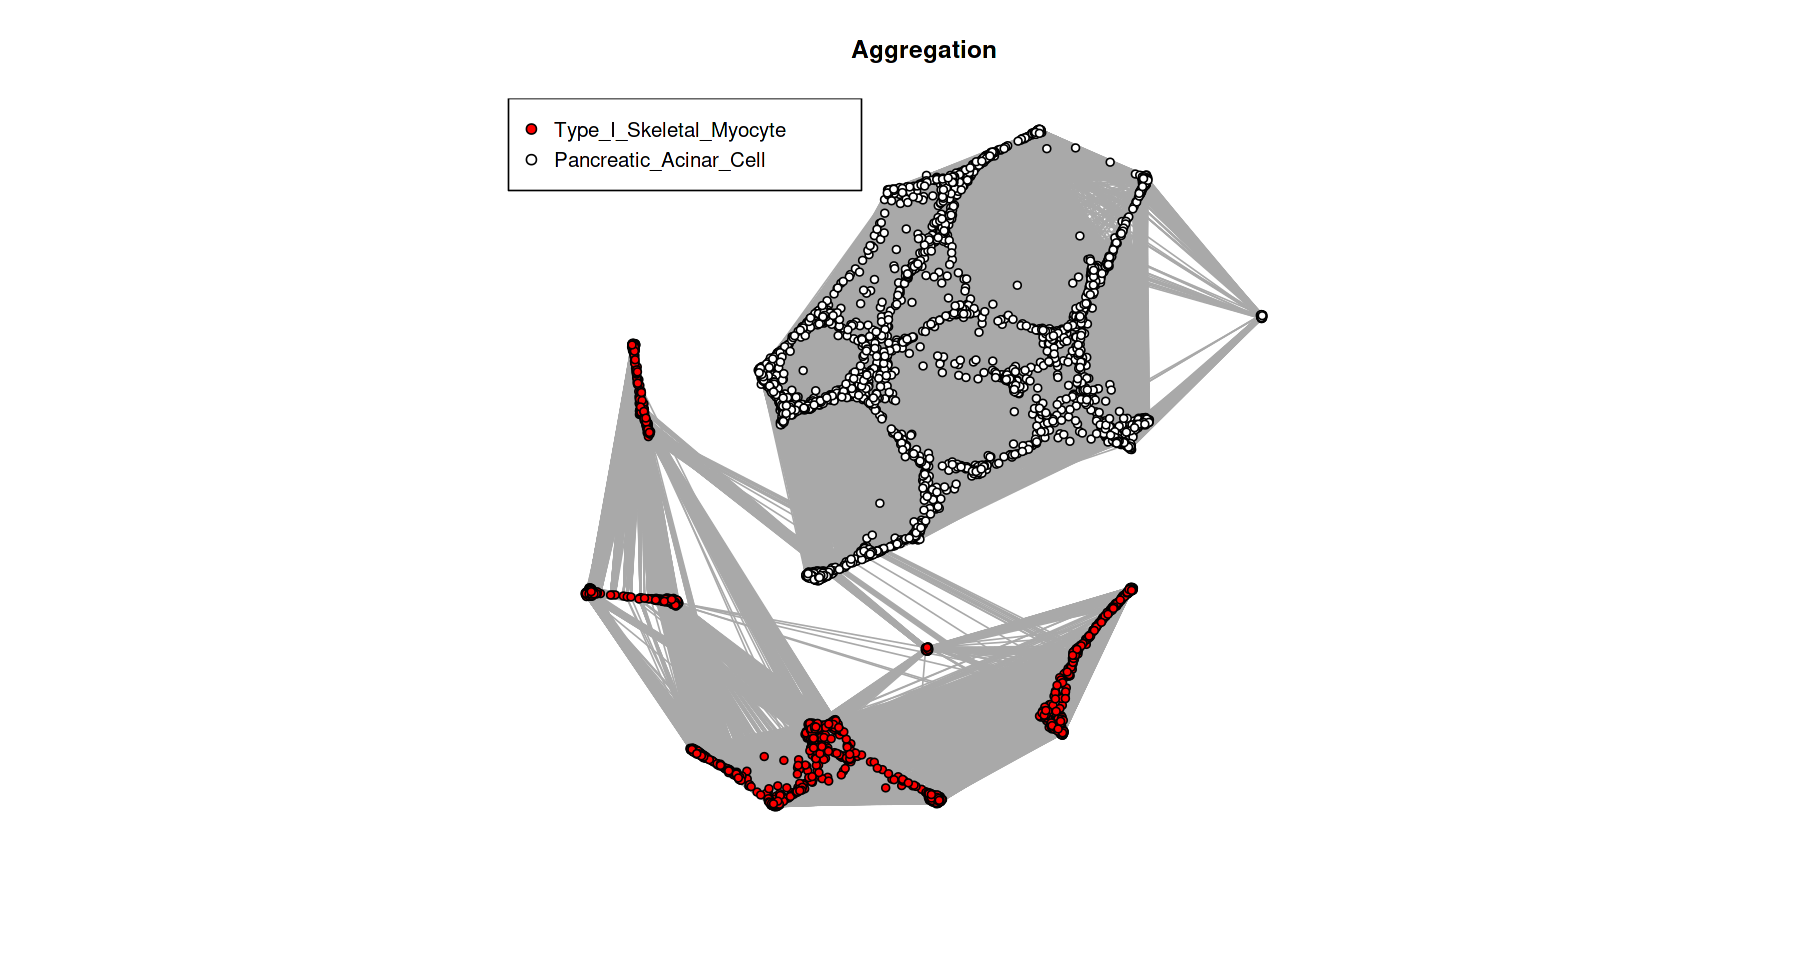

In [117]:
options(repr.plot.width=15, repr.plot.height=8)
plot(simplify(g1_s), vertex.label=NA, vertex.size=2, main="Signac_by_cluster_peaks") # remove loops and duplicated edges layout=layout.fruchterman.reingold
legend("topleft", legend=c("Type_I_Skeletal_Myocyte", "Pancreatic_Acinar_Cell"), pch=21, pt.bg=c("red","white"))
plot(simplify(g2_s), vertex.label=NA, vertex.size=2, main="Aggregation") # remove loops and duplicated edges
legend("topleft", legend=c("Type_I_Skeletal_Myocyte", "Pancreatic_Acinar_Cell"), pch=21, pt.bg=c("red","white"))

### Strong vs weak community

#### Muscle

In [150]:
community_strength <- function(graph, label){
    require(igraph)
    V(graph)$label <- label
    label_ls <- unique(label)
    df_graph <- as_data_frame(graph, what = c("edges"))
    
    v_1 <- V(graph)[V(graph)$label == label_ls[1]]
    v_2 <- V(graph)[V(graph)$label == label_ls[2]]
    
    l1 <- length(v_1)
    l2 <- length(v_2)
    
    j1 <- 0
    w1 <- 0
    for (i in v_1){
        df_tmp <- df_graph[df_graph$to == i | df_graph$from == i,] # edges of node i
        a <- sum(df_tmp$from %in% v_1 & df_tmp$to %in% v_1) # within cluster edges of node i
        b <- sum(df_tmp$from %in% v_1 & df_tmp$to %in% v_2) # between cluster edges of node i
        c <- sum(df_tmp$weight[df_tmp$from %in% v_1 & df_tmp$to %in% v_1])
        d <- sum(df_tmp$weight[df_tmp$from %in% v_1 & df_tmp$to %in% v_2])
        if(b>=a){j1 <- j1+1}
        if(d>=c){w1 <- w1+1}
    }
    j2 <- 0
    w2 <- 0
    for (i in v_2){
        df_tmp <- df_graph[df_graph$to == i | df_graph$from == i,] # edges of node i
        a <- sum(df_tmp$from %in% v_2 & df_tmp$to %in% v_2) # within cluster edges of node i
        b <- sum(df_tmp$from %in% v_2 & df_tmp$to %in% v_1) # between cluster edges of node i
        c <- sum(df_tmp$weight[df_tmp$from %in% v_2 & df_tmp$to %in% v_2])
        d <- sum(df_tmp$weight[df_tmp$from %in% v_2 & df_tmp$to %in% v_1])
        if(b>=a){j2 <- j2+1}
        if(d>=c){w2 <- w2+1}
    }
    return(list(j1=j1, j2=j2, j1_frac=j1/l1, j2_frac=j2/l2, w1=w1, w2=w2, w1_frac=w1/l1, w2_frac=w2/l2))
}

In [162]:
community_strength <- function(graph, label, label_idx=1){
    require(igraph)
    V(graph)$label <- label
    label_ls <- unique(label)
    df_graph <- as_data_frame(graph, what = c("edges"))
    
    if(label_idx == 1){
    v_1 <- V(graph)[V(graph)$label == label_ls[1]]
    v_2 <- V(graph)[V(graph)$label == label_ls[2]]
    }
    else if (label_idx == 2){
        v_1 <- V(graph)[V(graph)$label == label_ls[2]]
        v_2 <- V(graph)[V(graph)$label == label_ls[1]]
    }
    
    l1 <- length(v_1)
    
    j1 <- 0
    w1 <- 0
    for (i in v_1){
        df_tmp <- df_graph[df_graph$to == i | df_graph$from == i,] # edges of node i
        a <- sum(df_tmp$from %in% v_1 & df_tmp$to %in% v_1) # within cluster edges of node i
        b <- sum(df_tmp$from %in% v_1 & df_tmp$to %in% v_2) # between cluster edges of node i
        c <- sum(df_tmp$weight[df_tmp$from %in% v_1 & df_tmp$to %in% v_1])
        d <- sum(df_tmp$weight[df_tmp$from %in% v_1 & df_tmp$to %in% v_2])
        if(b>=a){j1 <- j1+1}
        if(d>=c){w1 <- w1+1}
    }
    return(list(j1=j1, j1_frac=j1/l1, w1=w1, w1_frac=w1/l1))
}

In [151]:
# community_strength(g1_muscle, V(g1_muscle)$cluster)

$j1
[1] 15

$j2
[1] 14

$j1_frac
[1] 0.006402049

$j2_frac
[1] 0.02811245

$w1
[1] 9

$w2
[1] 7

$w1_frac
[1] 0.003841229

$w2_frac
[1] 0.01405622

In [163]:
# muscle
community_strength(g1_muscle, V(g1_muscle)$cluster,1)
community_strength(g1_muscle, V(g1_muscle)$cluster,2)

$j1
[1] 15

$j1_frac
[1] 0.006402049

$w1
[1] 9

$w1_frac
[1] 0.003841229

$j1
[1] 14

$j1_frac
[1] 0.02811245

$w1
[1] 7

$w1_frac
[1] 0.01405622

In [152]:
# community_strength(g2_muscle, V(g2_muscle)$cluster)

$j1
[1] 12

$j2
[1] 14

$j1_frac
[1] 0.005121639

$j2_frac
[1] 0.02811245

$w1
[1] 4

$w2
[1] 9

$w1_frac
[1] 0.001707213

$w2_frac
[1] 0.01807229

In [154]:
# small intestinal
community_strength(g1_s, V(g1_s)$cluster)
community_strength(g2_s, V(g2_s)$cluster)

$j1
[1] 8

$j2
[1] 18

$j1_frac
[1] 0.00623053

$j2_frac
[1] 0.04864865

$w1
[1] 7

$w2
[1] 9

$w1_frac
[1] 0.005451713

$w2_frac
[1] 0.02432432

$j1
[1] 2

$j2
[1] 2

$j1_frac
[1] 0.001557632

$j2_frac
[1] 0.005405405

$w1
[1] 1

$w2
[1] 2

$w1_frac
[1] 0.0007788162

$w2_frac
[1] 0.005405405

In [157]:
# control
community_strength(g1_s, V(g1_s)$cluster)
community_strength(g2_s, V(g2_s)$cluster)

$j1
[1] 0

$j2
[1] 0

$j1_frac
[1] 0

$j2_frac
[1] 0

$w1
[1] 0

$w2
[1] 0

$w1_frac
[1] 0

$w2_frac
[1] 0

$j1
[1] 0

$j2
[1] 0

$j1_frac
[1] 0

$j2_frac
[1] 0

$w1
[1] 0

$w2
[1] 0

$w1_frac
[1] 0

$w2_frac
[1] 0

In [169]:
# try the whole graph
label <- as.numeric(ground_truth == "Smooth_Muscle_GE_Junction") + 1
community_strength(g1, label, 2)

$j1
[1] 17

$j1_frac
[1] 0.03413655

$w1
[1] 11

$w1_frac
[1] 0.02208835

In [170]:
community_strength(g2, label, 2)

$j1
[1] 16

$j1_frac
[1] 0.03212851

$w1
[1] 10

$w1_frac
[1] 0.02008032

In [171]:
label <- as.numeric(ground_truth == "Vascular_Smooth_Muscle_1") + 1
community_strength(g1, label, 2)
community_strength(g2, label, 2)

$j1
[1] 16

$j1_frac
[1] 0.006828852

$w1
[1] 9

$w1_frac
[1] 0.003841229

$j1
[1] 14

$j1_frac
[1] 0.005975245

$w1
[1] 6

$w1_frac
[1] 0.002560819

In [172]:
label <- as.numeric(ground_truth == "Small_Intestinal_Enterocyte") + 1
community_strength(g1, label, 2)
community_strength(g2, label, 2)

$j1
[1] 8

$j1_frac
[1] 0.00623053

$w1
[1] 7

$w1_frac
[1] 0.005451713

$j1
[1] 2

$j1_frac
[1] 0.001557632

$w1
[1] 1

$w1_frac
[1] 0.0007788162

In [173]:
label <- as.numeric(ground_truth == "Colonic_Goblet_Cell") + 1
community_strength(g1, label, 2)
community_strength(g2, label, 2)

$j1
[1] 18

$j1_frac
[1] 0.04864865

$w1
[1] 9

$w1_frac
[1] 0.02432432

$j1
[1] 2

$j1_frac
[1] 0.005405405

$w1
[1] 2

$w1_frac
[1] 0.005405405

In [174]:
label <- as.numeric(ground_truth == "Type_I_Skeletal_Myocyte") + 1
community_strength(g1, label, 2)
community_strength(g2, label, 2)

$j1
[1] 1

$j1_frac
[1] 0.0004987531

$w1
[1] 0

$w1_frac
[1] 0

$j1
[1] 0

$j1_frac
[1] 0

$w1
[1] 0

$w1_frac
[1] 0

In [175]:
label <- as.numeric(ground_truth == "Pancreatic_Acinar_Cell") + 1
community_strength(g1, label, 2)
community_strength(g2, label, 2)

$j1
[1] 0

$j1_frac
[1] 0

$w1
[1] 0

$w1_frac
[1] 0

$j1
[1] 0

$j1_frac
[1] 0

$w1
[1] 0

$w1_frac
[1] 0

### Assortativity

In [133]:
assortativity(g1, ground_truth, directed = FALSE)
assortativity(g2, ground_truth, directed = FALSE)

[1] 0.990569

[1] 0.9968183

In [134]:
assortativity_nominal(g1, ground_truth, directed = FALSE)
assortativity_nominal(g2, ground_truth, directed = FALSE)

[1] 0.9906975

[1] 0.9943395

In [132]:
assortativity.degree(g1, directed = FALSE)
assortativity.degree(g2, directed = FALSE)

[1] 0.4821576

[1] 0.3995347

In [21]:
idx <- ground_truth == "Vascular_Smooth_Muscle_1" | ground_truth == "Smooth_Muscle_GE_Junction" 
muscle_v1 <- V(g1)[idx]
muscle_v2 <- V(g2)[idx]
ground_truth_sub <- ground_truth[idx]

In [22]:
g1_muscle <- subgraph(g1, muscle_v1)
assortativity_nominal(g1_muscle , ground_truth_sub, directed = FALSE)
assortativity.degree(g1_muscle)

[1] 0.901052

[1] 0.475192

In [47]:
g2_muscle <- subgraph(g2, muscle_v2)
assortativity_nominal(g2_muscle , ground_truth_sub, directed = FALSE)
assortativity.degree(g2_muscle)

[1] 0.9089462

[1] 0.3806408

# ArchR_tiles

In [80]:
sobj1 <- readRDS("candidate1/ArchR_tiles_ndim15_r0.15seeds.RDS")

In [81]:
prediction_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/ArchR/tiles/500/default/15/r0.15.tsv"
clustering <- read.table(prediction_file, sep="\t")

In [82]:
meta <- sobj1[[]]
head(meta)

orig.ident
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG esophagus 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC esophagus 
                                                                            nCount_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              3102                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4617                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 13827                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4269                
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2462                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5627                
                                                                            nFeature_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              2799                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4283                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 11898                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4001                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2278                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5268                  
                                                                            ground_truth              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG Esophageal_Epithelial_Cell
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC Esophageal_Epithelial_Cell
                                                                            snn_ndim15_res.0.15
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 4                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 4                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 4                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 4                  
                                                                            seurat_clusters
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 4              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 4              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 4              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 4              
                                            

In [83]:
ARI(meta$ArchR_tiles_ndim15_r0.15_seed197 , clustering$clusterings) 
ARI(meta$ArchR_tiles_ndim15_r0.15_seed123 , clustering$clusterings) 
ARI(meta$ArchR_tiles_ndim15_r0.15_seed5 , clustering$clusterings) 
ARI(meta$ArchR_tiles_ndim15_r0.15_seed2 , clustering$clusterings) 
ARI(meta$ArchR_tiles_ndim15_r0.15_seed42 , clustering$clusterings) 

[1] 1

[1] 0.9992171

[1] 0.9992171

[1] 0.9992171

[1] 0.9992171

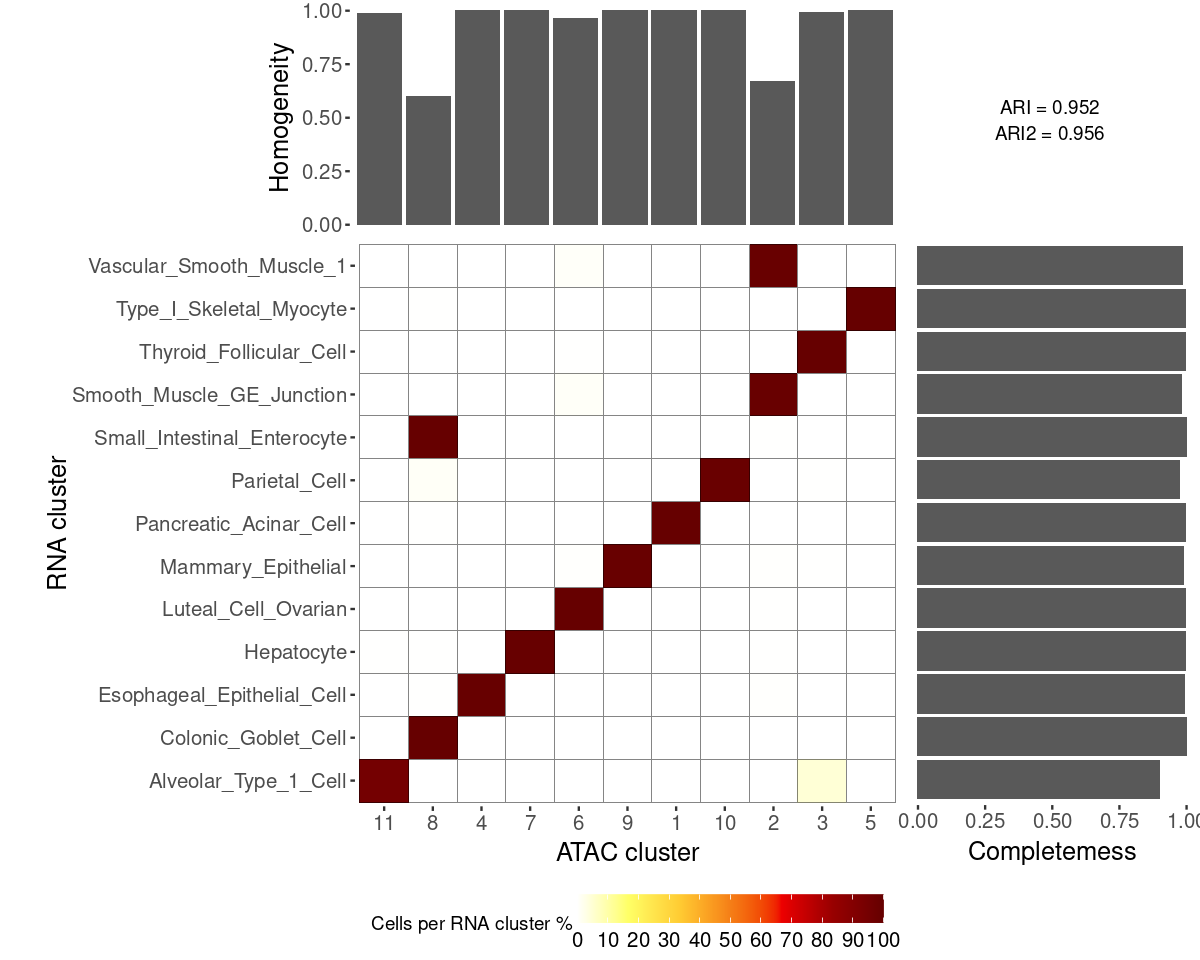

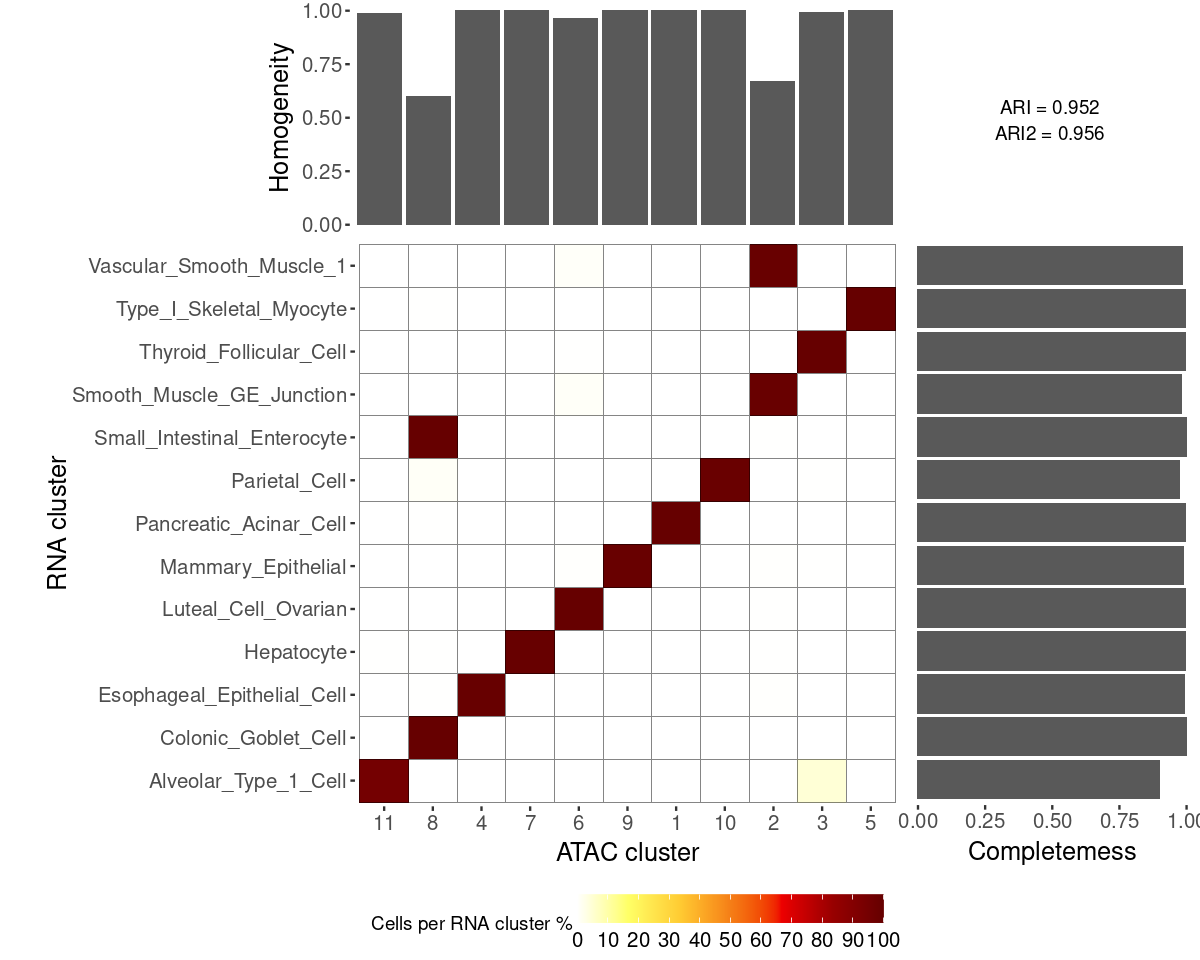

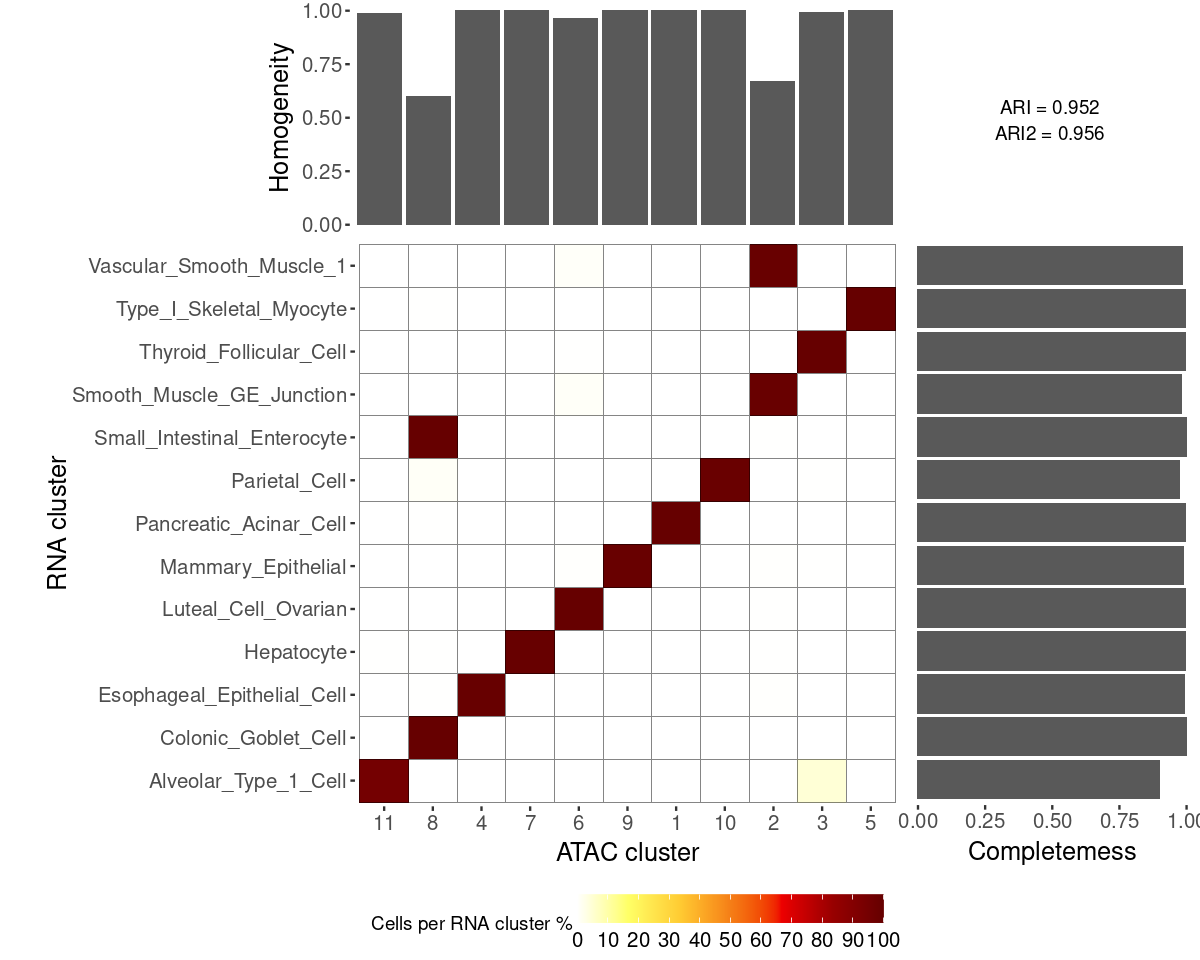

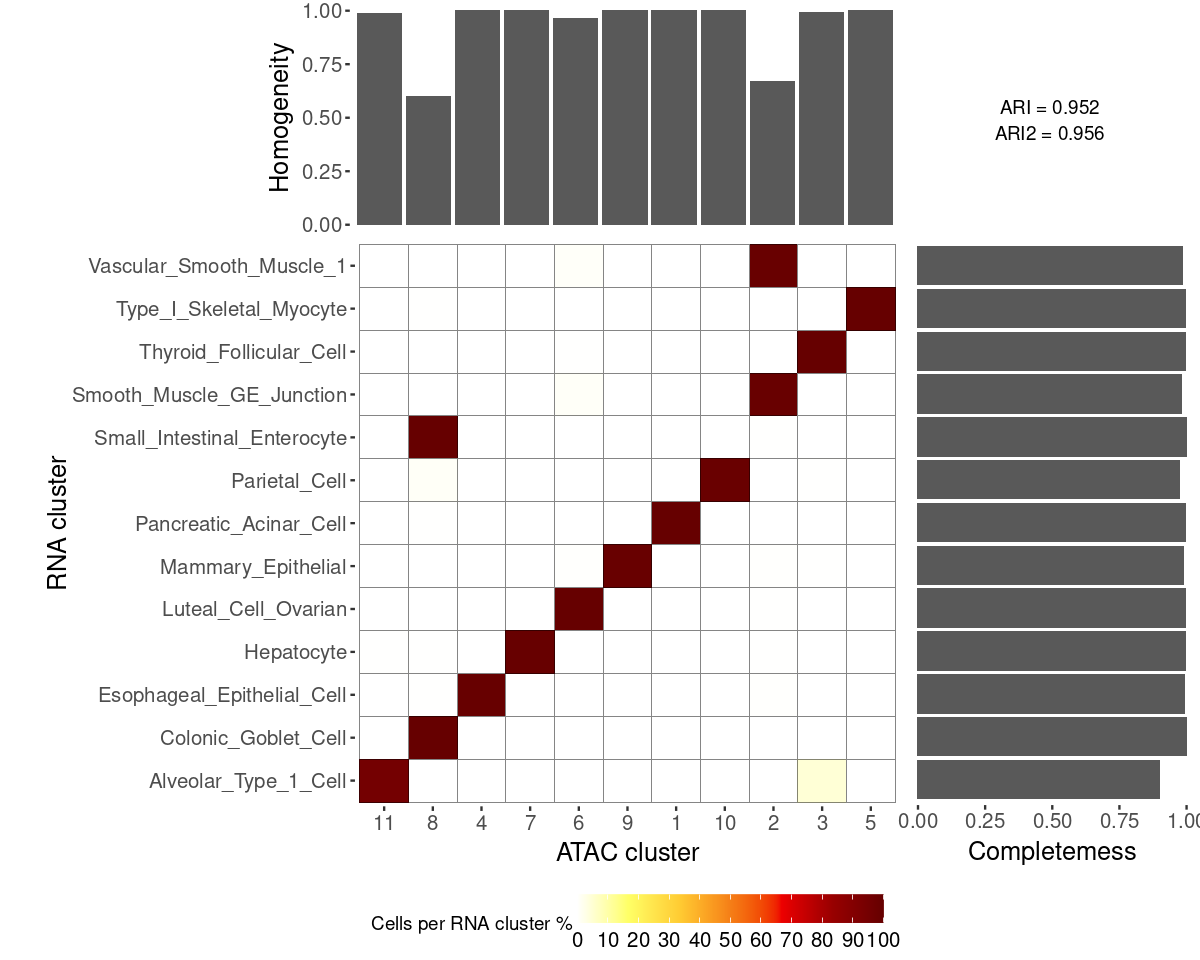

In [84]:
ground_truth <- sobj1$ground_truth
options(repr.plot.width=10, repr.plot.height=8)
cross_table_plot(ground_truth, meta$ArchR_tiles_ndim15_r0.15_seed123, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_tiles_ndim15_r0.15_seed5, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_tiles_ndim15_r0.15_seed2, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_tiles_ndim15_r0.15_seed42, a=1.3, b=5.7, c=2)

# ArchR_peaks

In [85]:
sobj1 <- readRDS("candidate1/ArchR_peaks_ndim15_r0.15seeds.RDS")

In [86]:
prediction_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/ArchR/peaks/500/default/15/r0.15.tsv"
clustering <- read.table(prediction_file, sep="\t")

In [87]:
meta <- sobj1[[]]
head(meta)

orig.ident
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG esophagus 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC esophagus 
                                                                            nCount_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              3102                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4617                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 13827                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4269                
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2462                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5627                
                                                                            nFeature_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              2799                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4283                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 11898                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4001                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2278                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5268                  
                                                                            ground_truth              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG Esophageal_Epithelial_Cell
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC Esophageal_Epithelial_Cell
                                                                            snn_ndim15_res.0.15
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3                  
                                                                            seurat_clusters
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3              
                                            

In [64]:
ARI(meta$ArchR_peaks_ndim15_r0.15_seed197 , clustering$clusterings) 
ARI(meta$ArchR_peaks_ndim15_r0.15_seed123 , clustering$clusterings) 
ARI(meta$ArchR_peaks_ndim15_r0.15_seed5 , clustering$clusterings) 
ARI(meta$ArchR_peaks_ndim15_r0.15_seed2 , clustering$clusterings) 
ARI(meta$ArchR_peaks_ndim15_r0.15_seed42 , clustering$clusterings) 

[1] 0.9997645

[1] 0.9997645

[1] 0.9997645

[1] 0.9997645

[1] 1

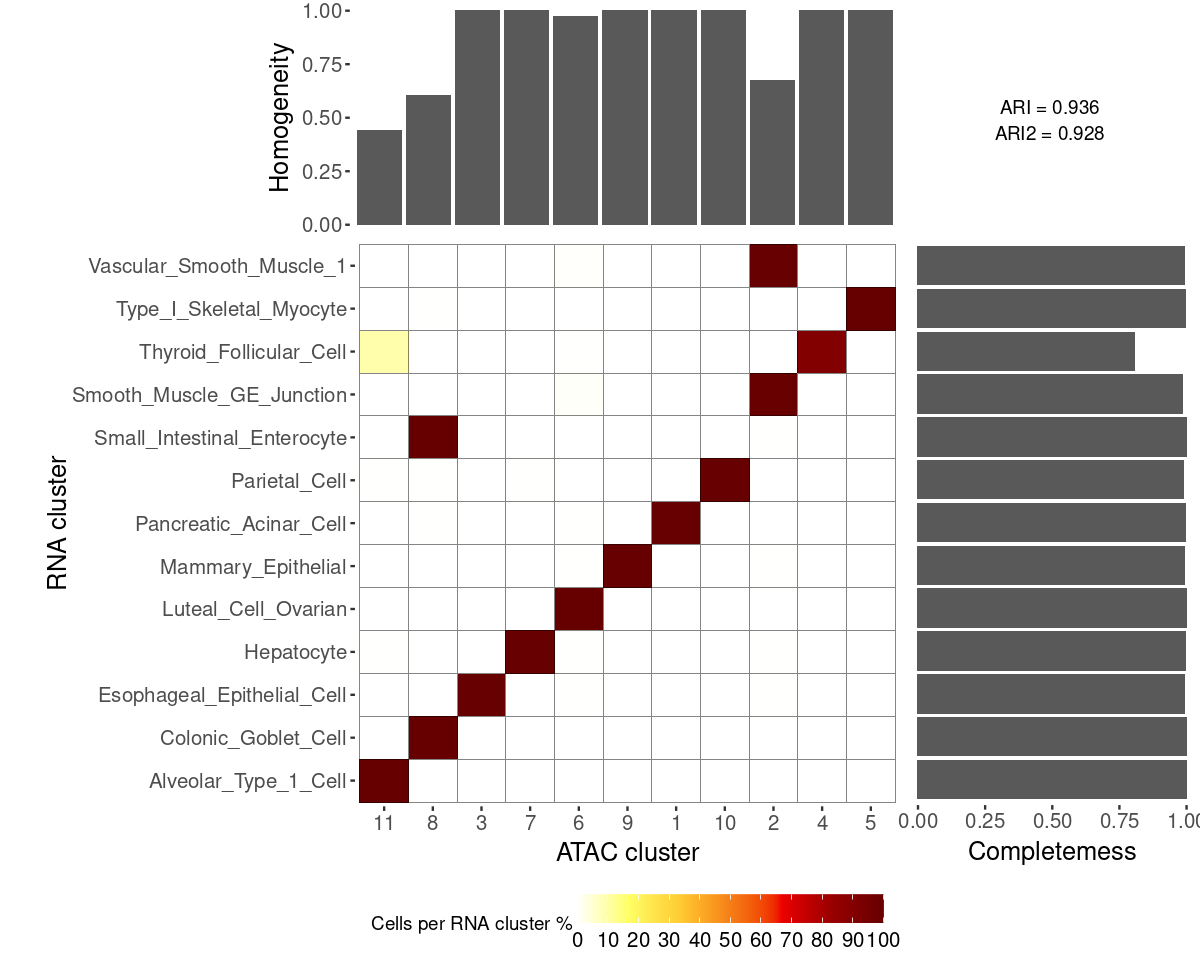

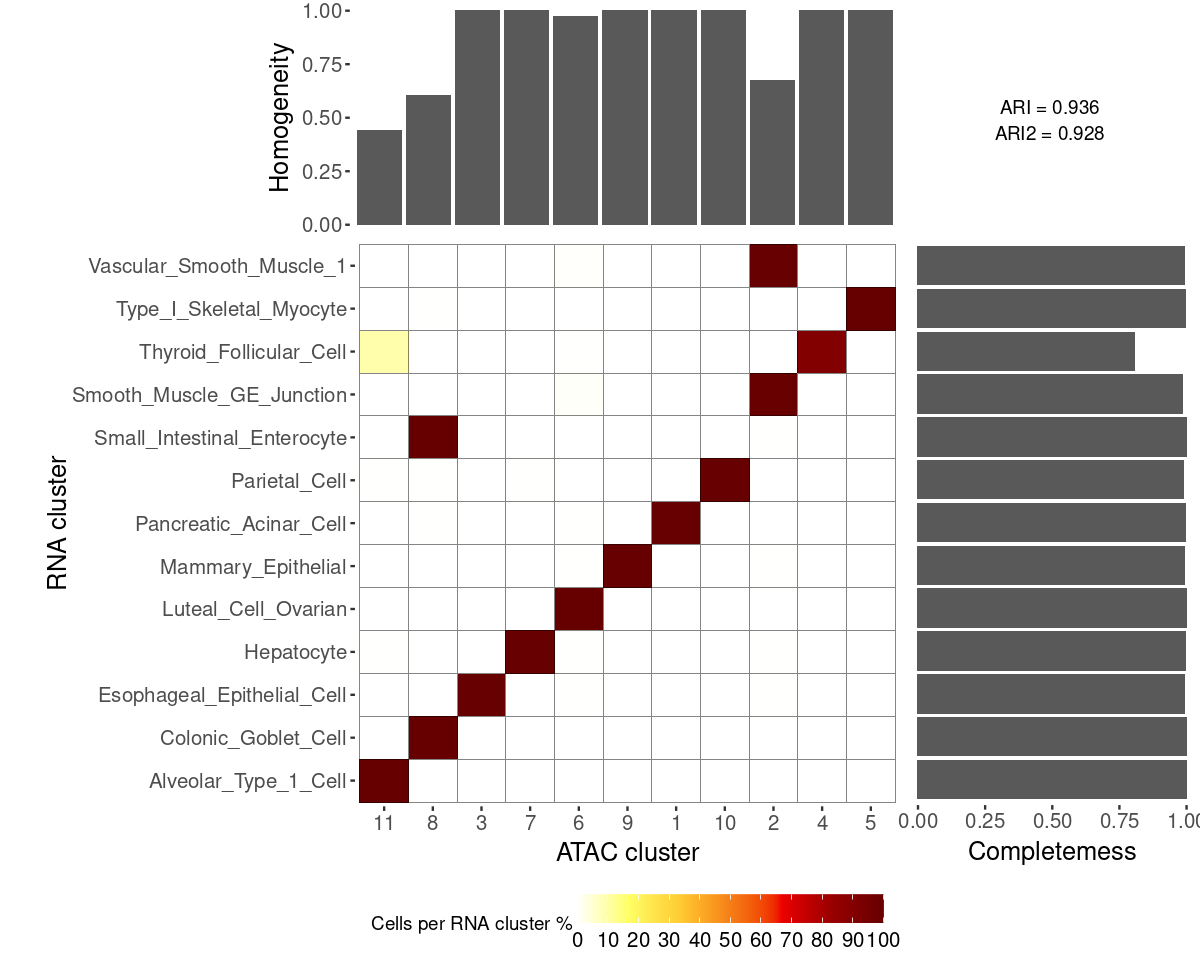

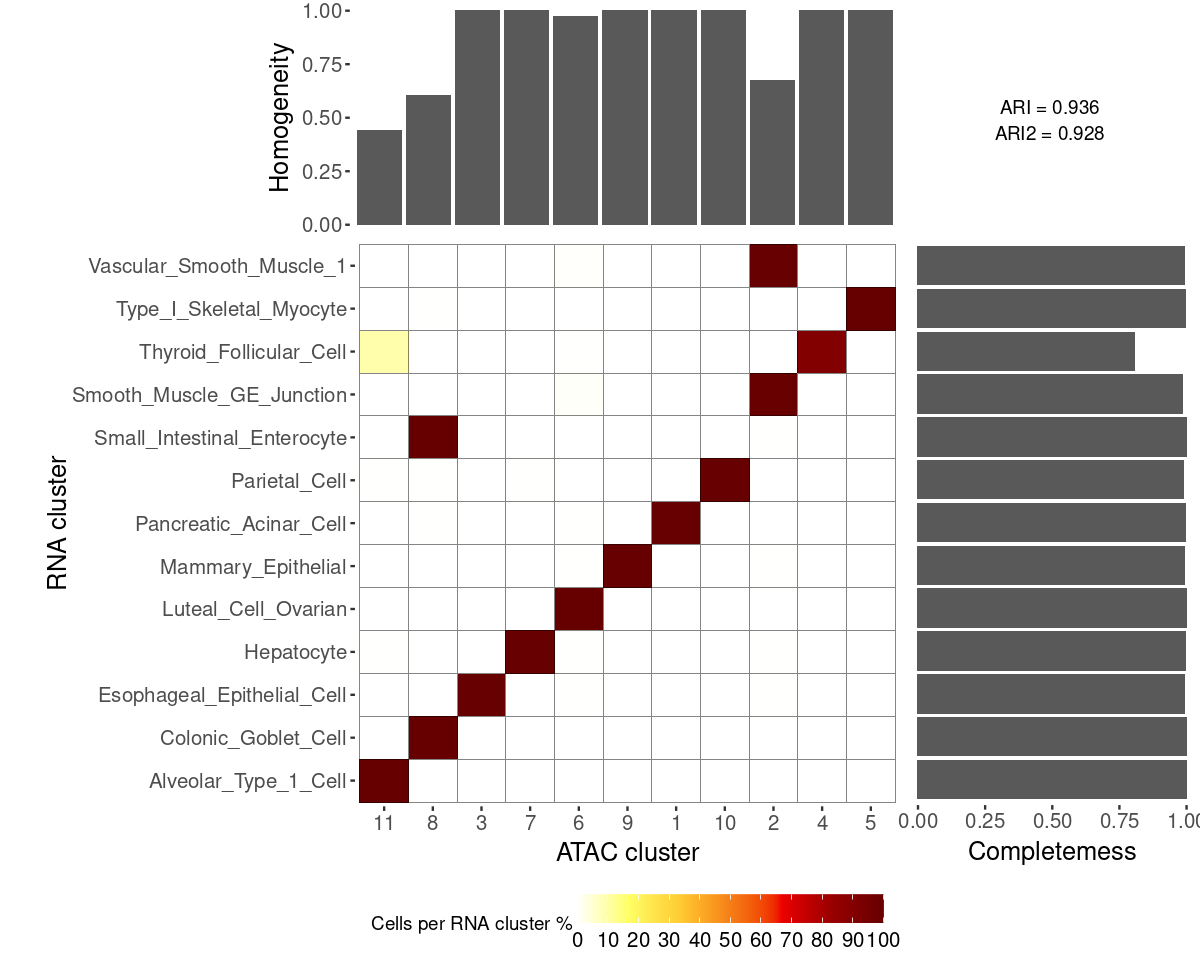

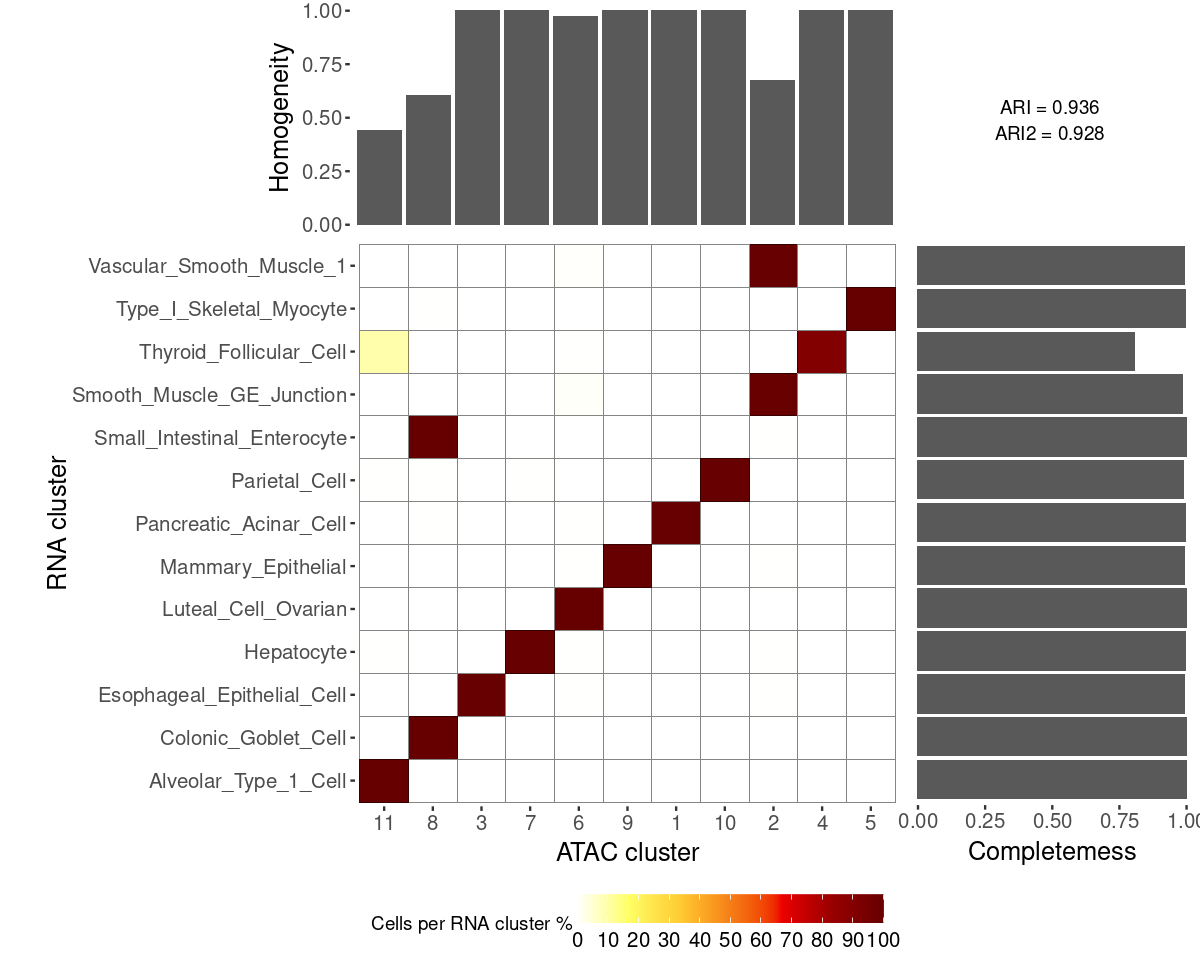

In [88]:
ground_truth <- sobj1$ground_truth
options(repr.plot.width=10, repr.plot.height=8)
cross_table_plot(ground_truth, meta$ArchR_peaks_ndim15_r0.15_seed123, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_peaks_ndim15_r0.15_seed5, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_peaks_ndim15_r0.15_seed2, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$ArchR_peaks_ndim15_r0.15_seed197, a=1.3, b=5.7, c=2)

ArchR has overall very stable results across different random seeds.

# SnapATAC1

In [89]:
sobj1 <- readRDS("candidate1/SnapATAC1_ndim15_r0.3seeds.RDS")

In [90]:
prediction_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/SnapATAC1/default/5000/default/15/r0.3.tsv"
clustering <- read.table(prediction_file, sep="\t")

In [91]:
meta <- sobj1[[]]
head(meta)

orig.ident
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA esophagus 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG esophagus 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             pancreas  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC esophagus 
                                                                            nCount_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              3102                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4617                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 13827                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4269                
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2462                
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5627                
                                                                            nFeature_all_cell_peaks
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC              2799                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT  4283                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 11898                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG  4001                  
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG              2278                  
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC  5268                  
                                                                            ground_truth              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA Esophageal_Epithelial_Cell
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG Esophageal_Epithelial_Cell
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             Pancreatic_Acinar_Cell    
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC Esophageal_Epithelial_Cell
                                                                            snn_ndim15_res.0.3
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1                 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3                 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3                 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3                 
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1                 
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3                 
                                                                            seurat_clusters
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+GGACGATAAGTTAGGTAGCAAC             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CAACCTCATTAGGAACGCCGAT 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+TCATTGTCTGCGATTTCACCGA 3              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+AGCTGGAGTAGATCCATTCGTG 3              
pancreas_SM-IOBHS:Pancreatic_Acinar_Cell+CCAGTAGGGTCTTGAGACTCCG             1              
esophagus_mucosa_SM-AZPYJ:Esophageal_Epithelial_Cell+CCTATGTGTAAGATTTGAGTCC 3              
                                                   

In [68]:
ARI(meta$SnapATAC1_ndim15_r0.3_seed197 , clustering$clusterings) 
ARI(meta$SnapATAC1_ndim15_r0.3_seed123 , clustering$clusterings) 
ARI(meta$SnapATAC1_ndim15_r0.3_seed5 , clustering$clusterings) 
ARI(meta$SnapATAC1_ndim15_r0.3_seed2 , clustering$clusterings) 
ARI(meta$SnapATAC1_ndim15_r0.3_seed42 , clustering$clusterings) 

[1] 0.9978348

[1] 1

[1] 0.9621421

[1] 0.9496433

[1] 1

In [69]:
ground_truth <- sobj1$ground_truth

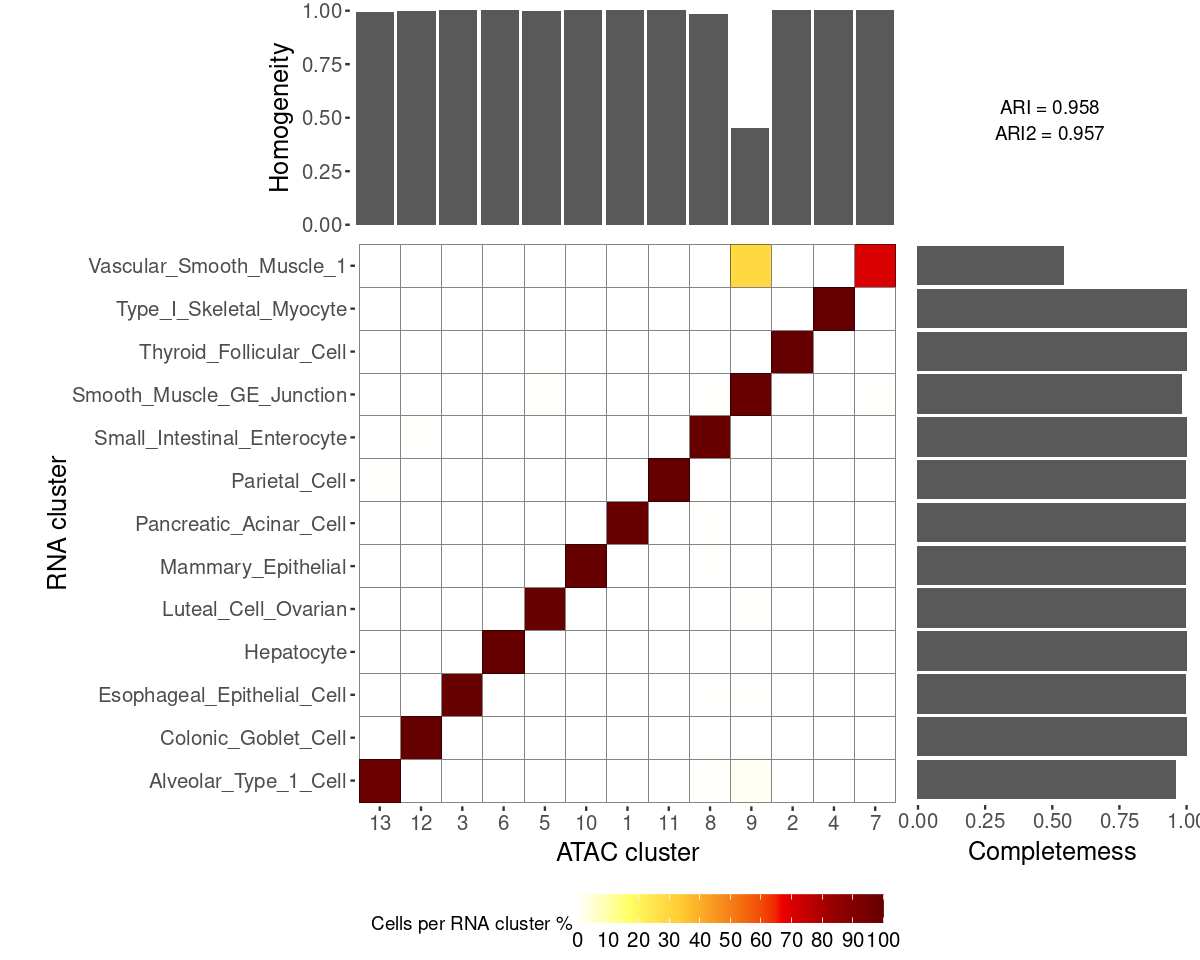

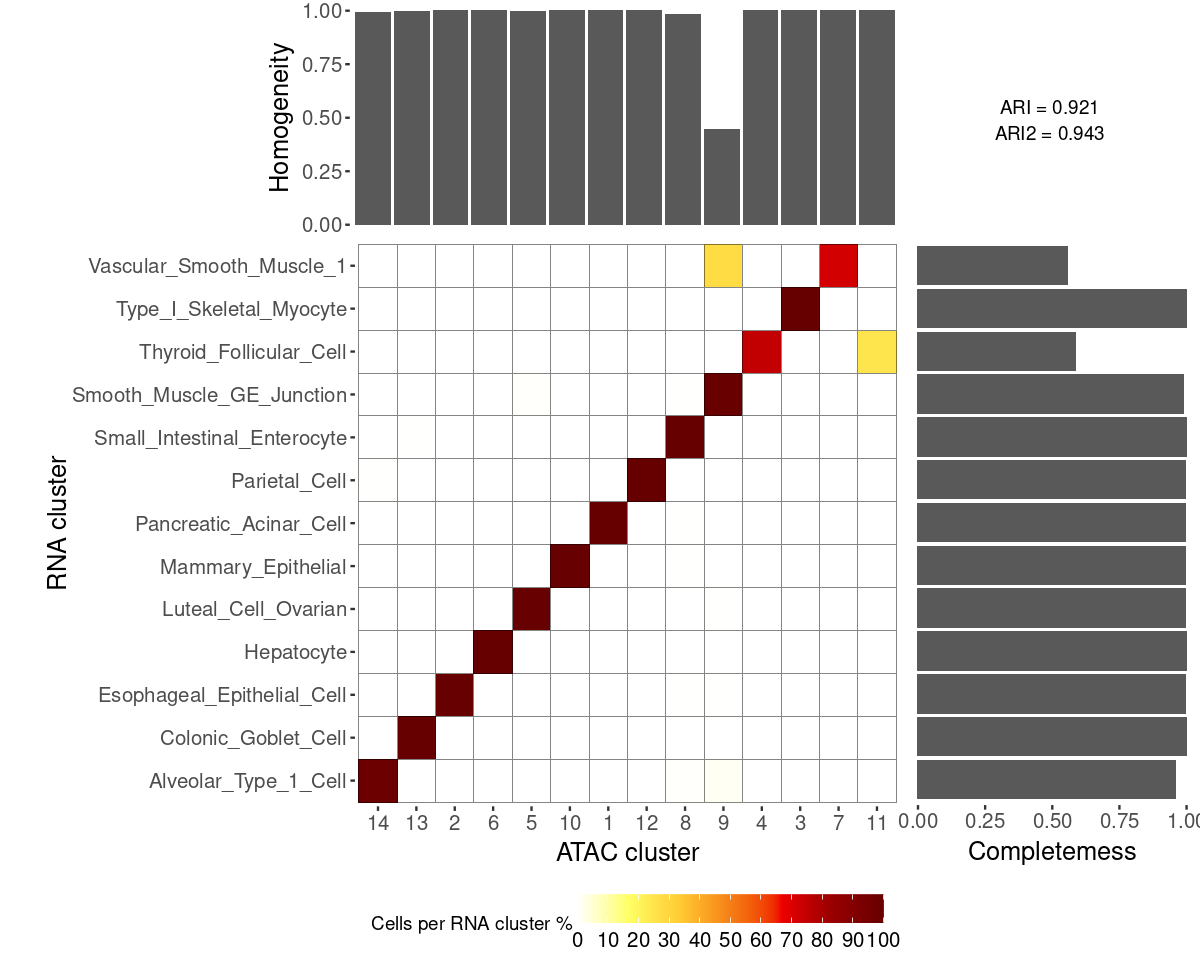

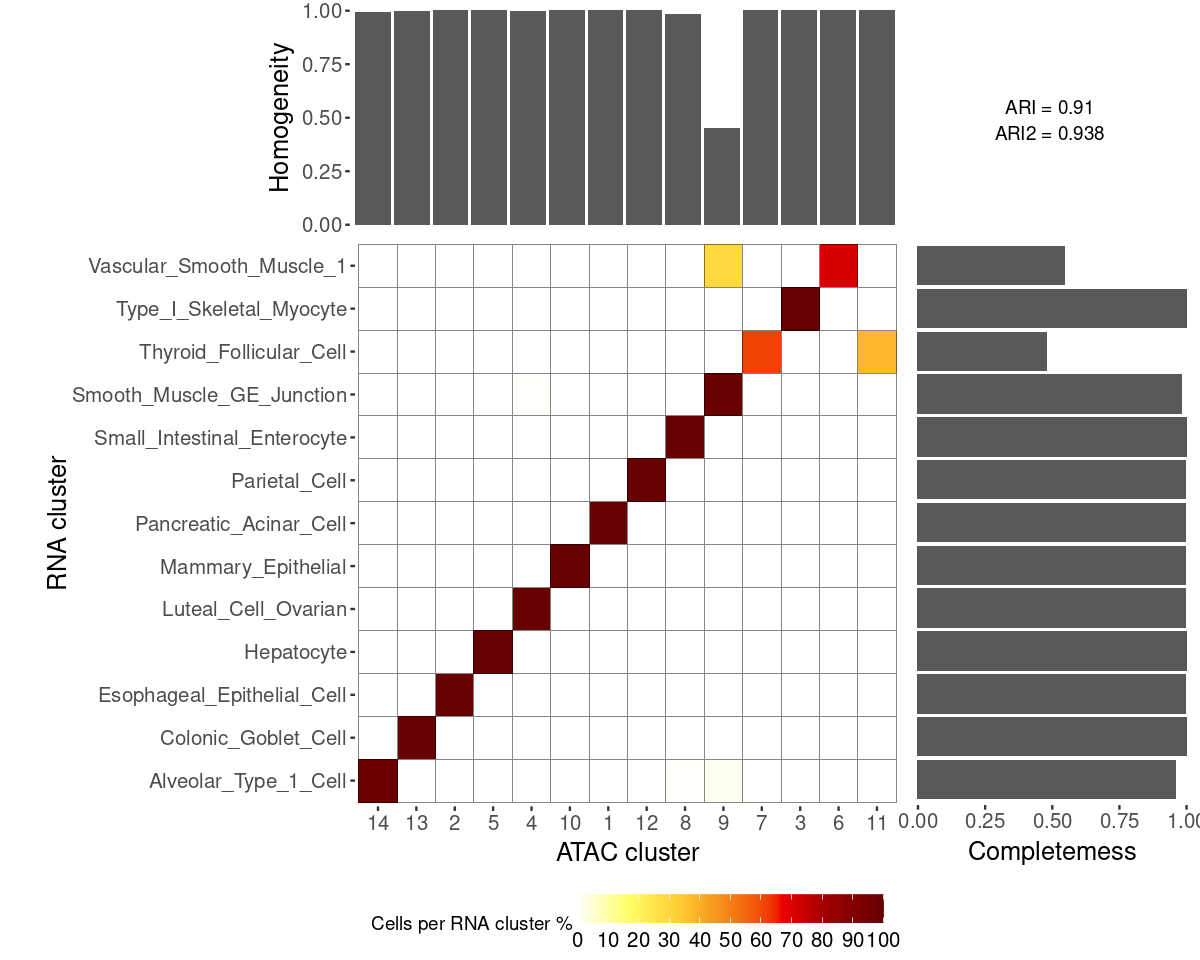

In [71]:
options(repr.plot.width=10, repr.plot.height=8)
cross_table_plot(ground_truth, meta$SnapATAC1_ndim15_r0.3_seed197, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$SnapATAC1_ndim15_r0.3_seed5, a=1.3, b=5.7, c=2)
cross_table_plot(ground_truth, meta$SnapATAC1_ndim15_r0.3_seed2, a=1.3, b=5.7, c=2)

SnapATAC1 has very variable solutions, but are overall not better than the original ones.